# DCGAN (Deep Convolutional Generative Adversarial Network)

- Published in 2015 by Radford et al.
- Similar to the original GAN, but uses Deep Convolutional Networks instead of fully-connected
- This implies that the DCGAN is more suitable to work with images and videos
- The generator receive as input a random noise and returns a **fake** image
- The discriminator receives as input real and fake images and returns a value between **0** and **1** to indicates how much true is the image
- Uses **binary cross-entropy** as loss function
- The generator don't see the real images, just learns by the discriminator feedback

# Importing Libraries

In [1]:
import numpy      as np
import tensorflow as tf

from tensorflow import keras

In [2]:
import matplotlib.pyplot as plt
import matplotlib        as mpl

## Versions

In [3]:
print(f"Numpy: {np.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"Matplotlib: {mpl.__version__}")

Numpy: 1.22.4
Tensorflow: 2.12.0
Keras: 2.12.0
Matplotlib: 3.7.1


# Data Preprocessing

In [4]:
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
X_train.shape

(60000, 28, 28)

60000 images 28x28

In [6]:
y_train.shape

(60000,)

60000 labels

## Visualizating

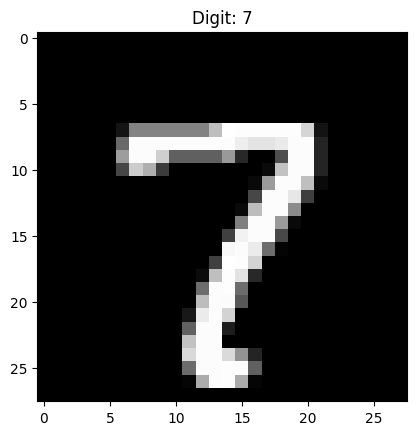

In [7]:
i = np.random.randint(0, 60000)

plt.imshow(X_train[i], cmap="gray")

plt.title(f"Digit: {y_train[i]}")

plt.show()

The original images have **3** channels of colors, so let's take only **1**

## Reshape

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")

## Normalize

The `max` and `min` value for a pixel

In [9]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

Now we need to **normalize** the values. When using GAN's it's usual normalize in [-1, 1] scale

In [10]:
medium_value = (255 - 0) / 2

medium_value

127.5

In [11]:
X_train = (X_train - medium_value) / medium_value

So now, the `min` and `max` are

In [12]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

## Batches

In [13]:
BUFFER_SIZE = 60000
BATCH_SIZE  = 256

In [14]:
BUFFER_SIZE / BATCH_SIZE

234.375

This mean we have **234 batches** and each batch with **256 images**.

## Creating Dataset

In [15]:
type(X_train)

numpy.ndarray

In [16]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [17]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

# Creating **Generator**

In [18]:
def generator():
  net = keras.Sequential(name="Generator")

  net.add(keras.layers.Dense(units=7*7*BATCH_SIZE, use_bias=False, input_shape=(100,)))
  net.add(keras.layers.BatchNormalization())
  net.add(keras.layers.LeakyReLU())

  net.add(keras.layers.Reshape((7, 7, BATCH_SIZE)))

  # 7 x 7 x 128
  net.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), padding="same", use_bias=False))
  net.add(keras.layers.BatchNormalization())
  net.add(keras.layers.LeakyReLU())

  # 14 x 14 x 64
  net.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), padding="same", use_bias=False, strides=(2, 2)))
  net.add(keras.layers.BatchNormalization())
  net.add(keras.layers.LeakyReLU())

  # 28 x 28 x 1
  net.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), padding="same", use_bias=False, strides=(2, 2), activation="tanh"))

  net.summary()

  return net

In [19]:
gen_net = generator()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

In [20]:
gen_net.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [21]:
noise = tf.random.normal([1, 100])

generated_image = gen_net(noise, training=False)

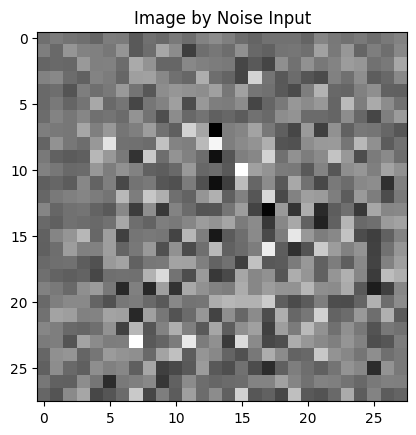

In [22]:
plt.imshow(generated_image[0, :, :, 0], cmap="gray")

plt.title("Image by Noise Input")

plt.show()

# Creating **Discriminator**

In [23]:
def discriminator():
  net = keras.Sequential(name="Discriminator")

  # 14 x 14 x 64
  net.add(keras.layers.Conv2D(filters=64, strides=(2, 2), kernel_size=(5, 5), padding="same", input_shape=[28, 28, 1]))
  net.add(keras.layers.LeakyReLU())
  net.add(keras.layers.Dropout(0.3))

  # 7 x 7 x 128
  net.add(keras.layers.Conv2D(filters=128, strides=(2, 2), kernel_size=(5, 5), padding="same"))
  net.add(keras.layers.LeakyReLU())
  net.add(keras.layers.Dropout(0.3))

  net.add(keras.layers.Flatten())
  net.add(keras.layers.Dense(1)) # Output is logits

  net.summary()

  return net

In [24]:
dsc_net = discriminator()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [25]:
dsc_net.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [26]:
dsc_net(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00158549]], dtype=float32)>

# Error

In [27]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def dsc_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

In [29]:
def gen_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer

In [30]:
gen_optim = keras.optimizers.Adam(learning_rate=0.00001)
dsc_optim = keras.optimizers.Adam(learning_rate=0.00001)

# Train

In [31]:
EPOCHS     = 100
NOISE_DIM  = 100
NUM_IMAGES = 16

In [32]:
@tf.function
def train(images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    generated_images = gen_net(noise, training=True)

    expected_output = dsc_net(images, training=True)
    fake_output     = dsc_net(generated_images, training=True)

    gen_loss_value = gen_loss(fake_output)
    dsc_loss_value = dsc_loss(expected_output, fake_output)
  
  gen_gradients = gen_tape.gradient(gen_loss_value, gen_net.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss_value, dsc_net.trainable_variables)

  gen_optim.apply_gradients(zip(gen_gradients, gen_net.trainable_variables))
  dsc_optim.apply_gradients(zip(dsc_gradients, dsc_net.trainable_variables))

In [33]:
test_images = tf.random.normal([NUM_IMAGES, NOISE_DIM])

test_images.shape

TensorShape([16, 100])

In [34]:
def gan_train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train(image_batch)
    
    print(f"Epoch {epoch + 1}")
    generated_images = gen_net(test_images, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(generated_images.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(generated_images[i, :, :, 0] * medium_value + medium_value, cmap="gray")
      plt.axis("off")
    
    plt.show()

Epoch 1


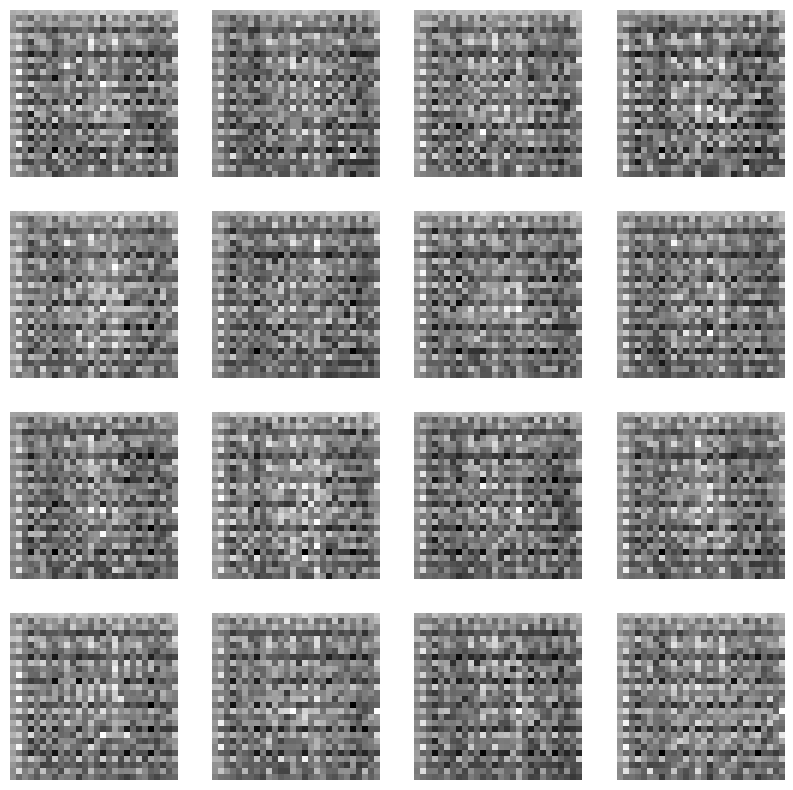

Epoch 2


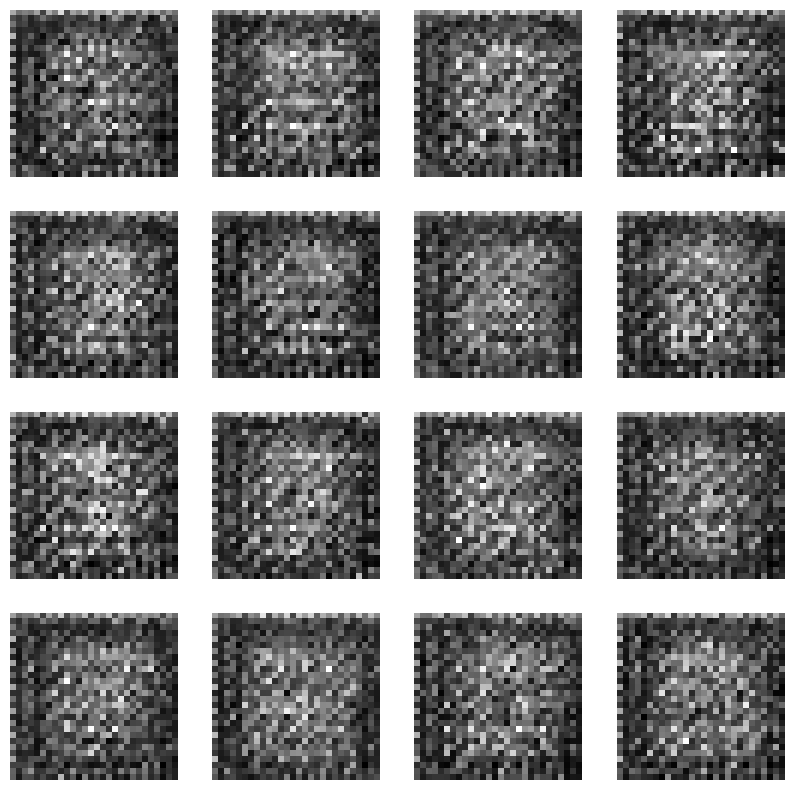

Epoch 3


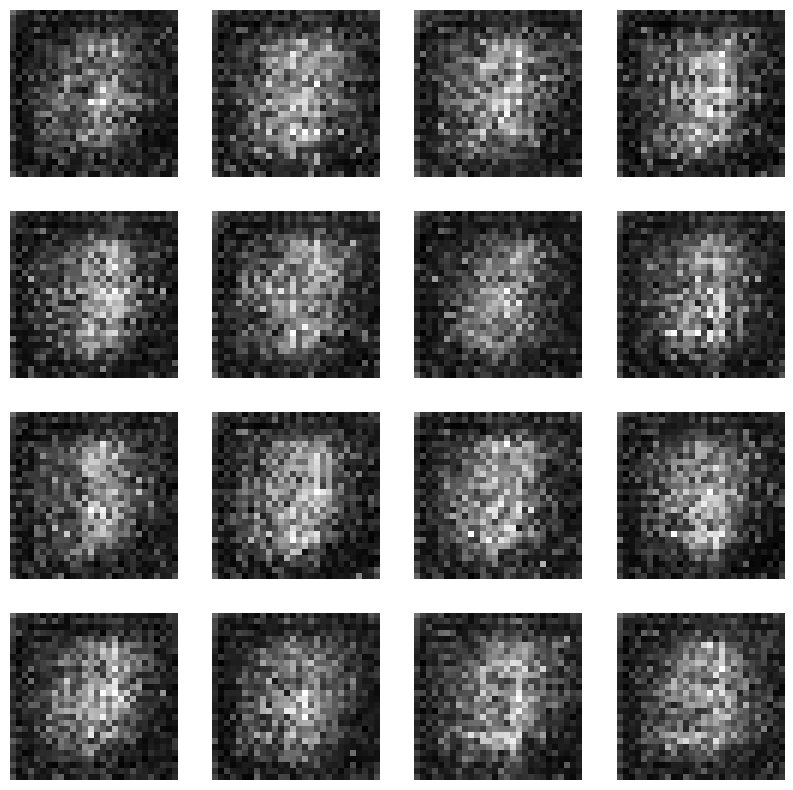

Epoch 4


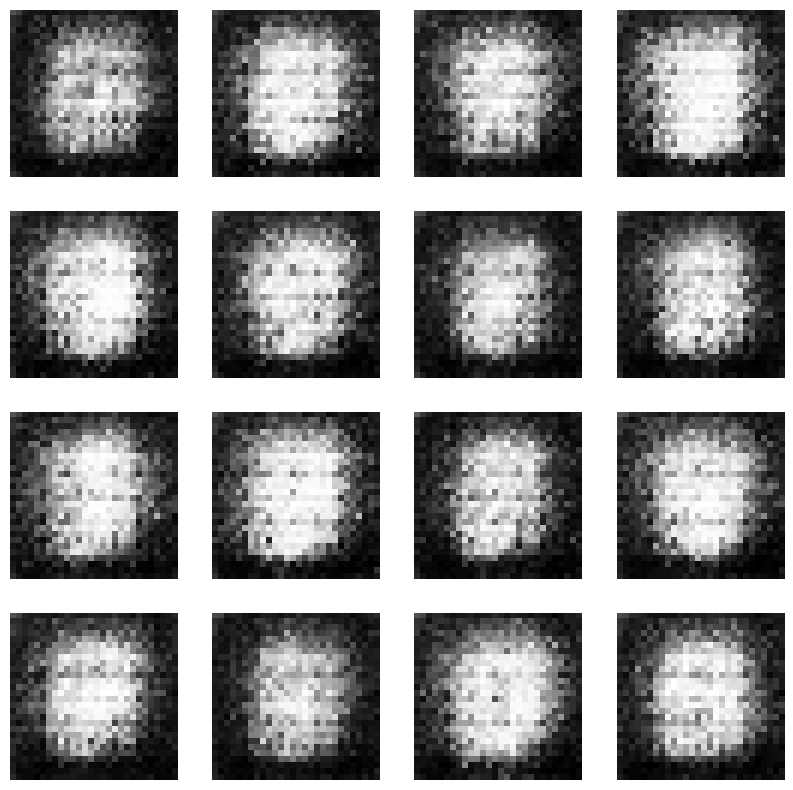

Epoch 5


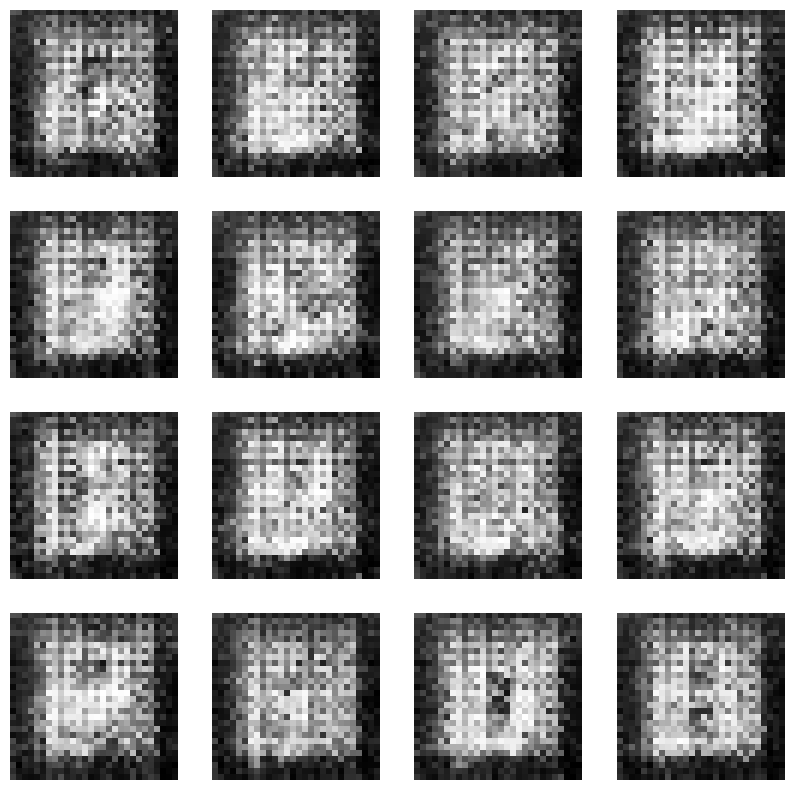

Epoch 6


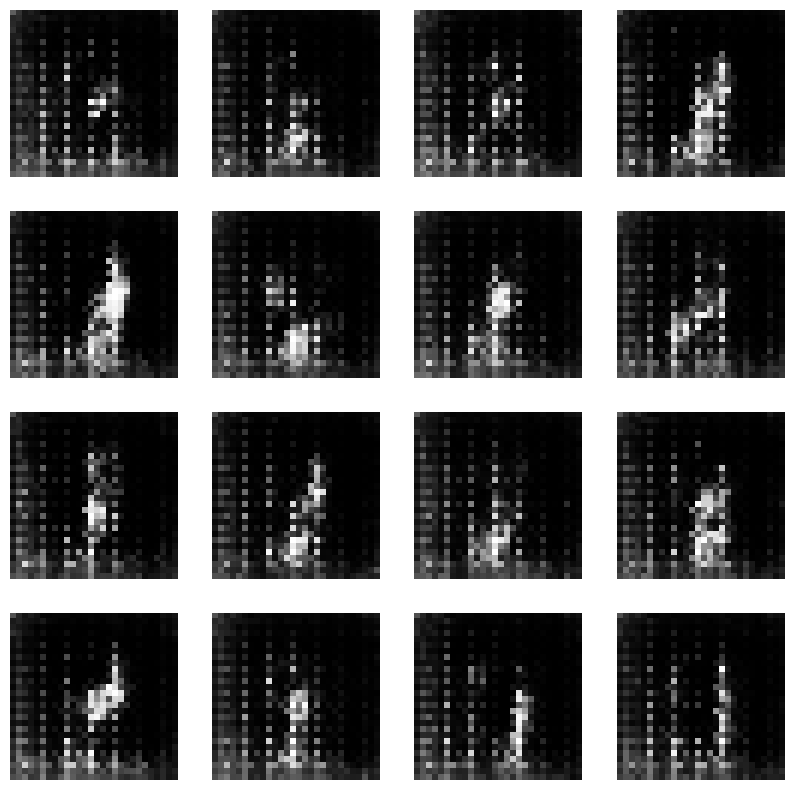

Epoch 7


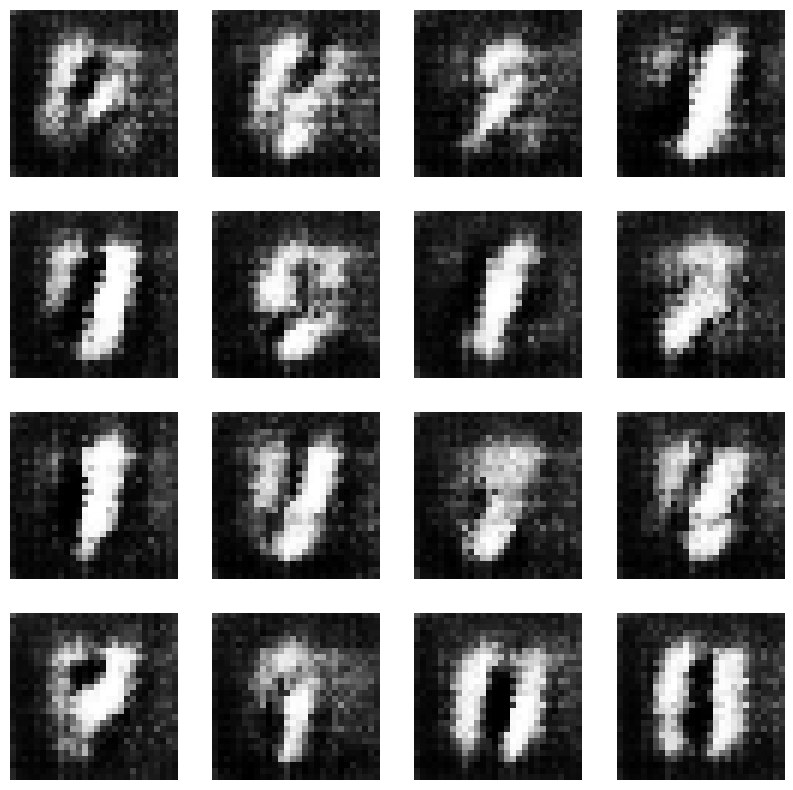

Epoch 8


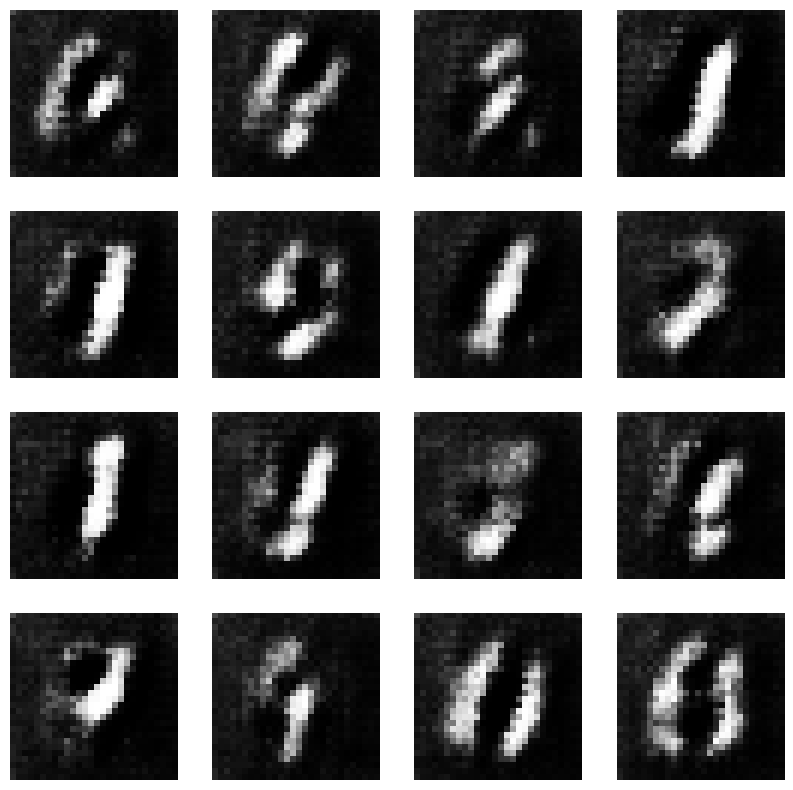

Epoch 9


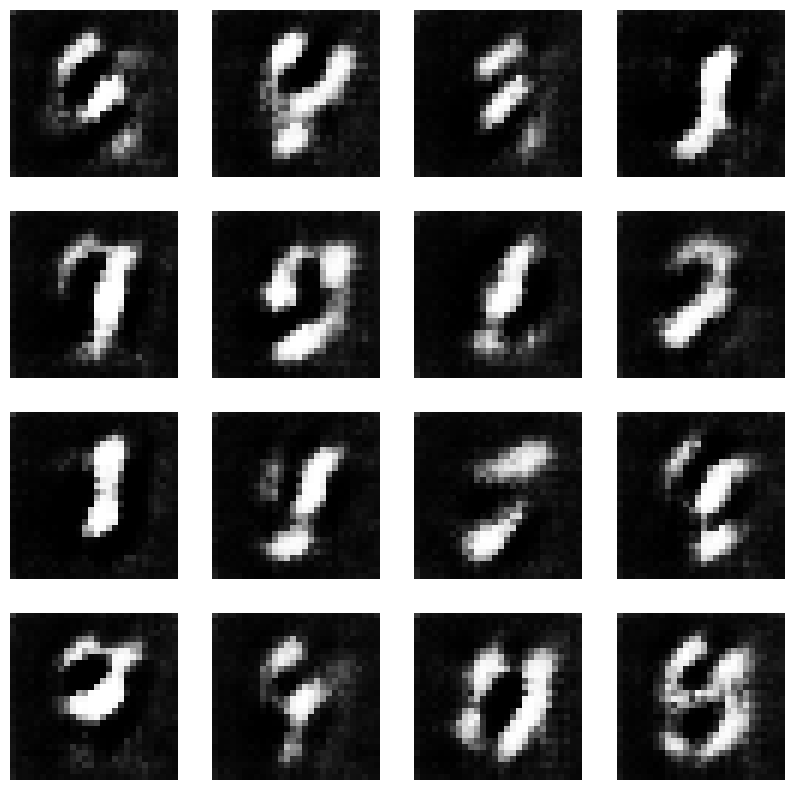

Epoch 10


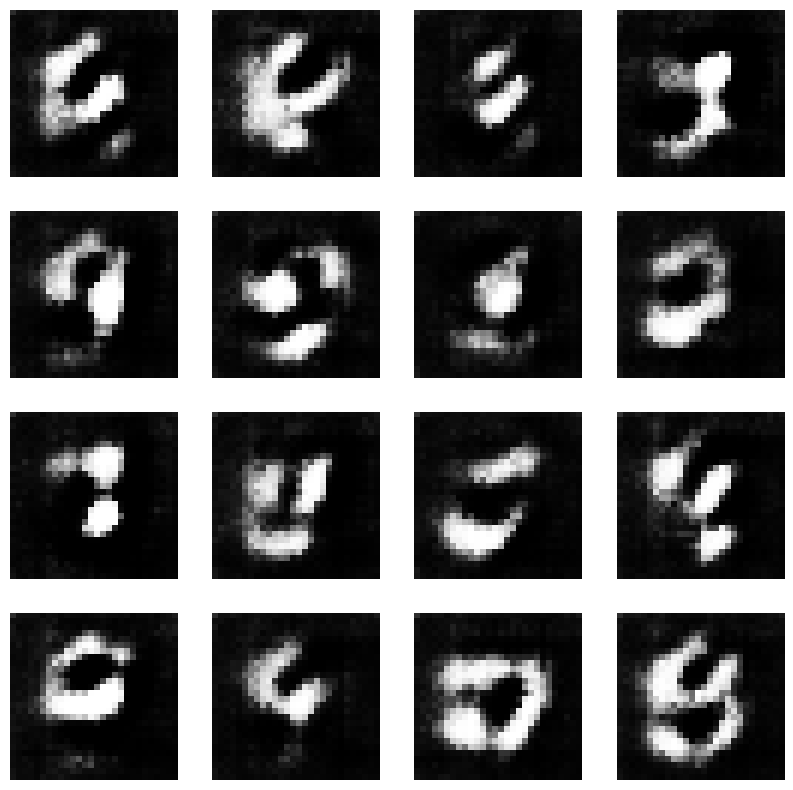

Epoch 11


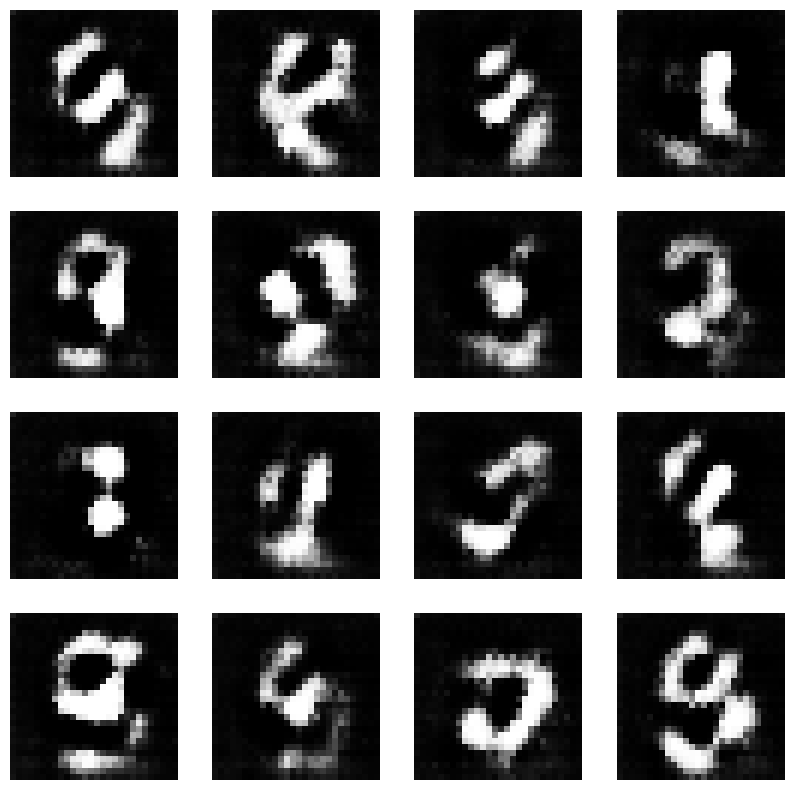

Epoch 12


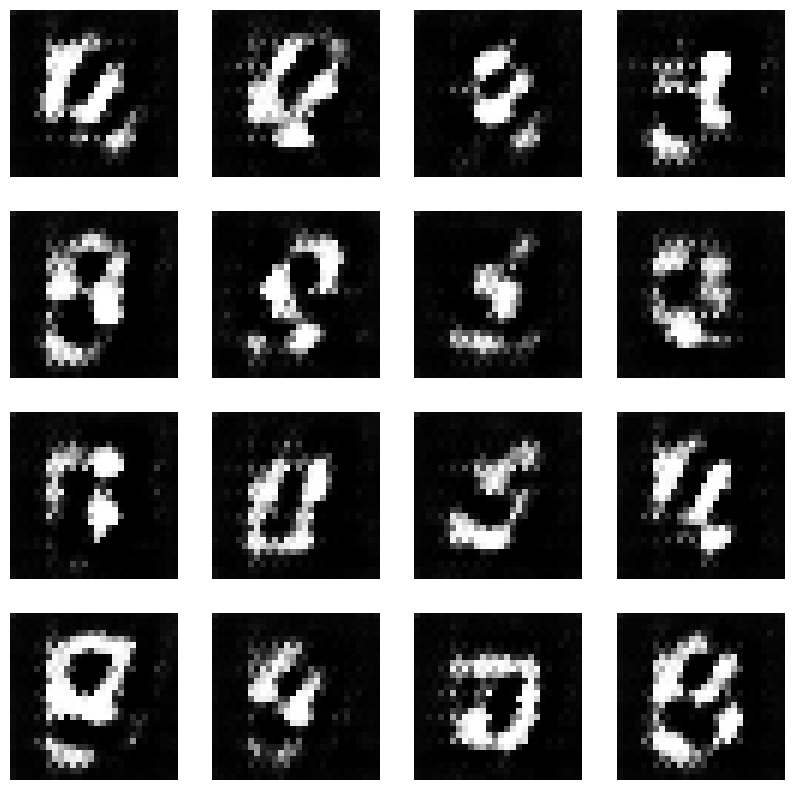

Epoch 13


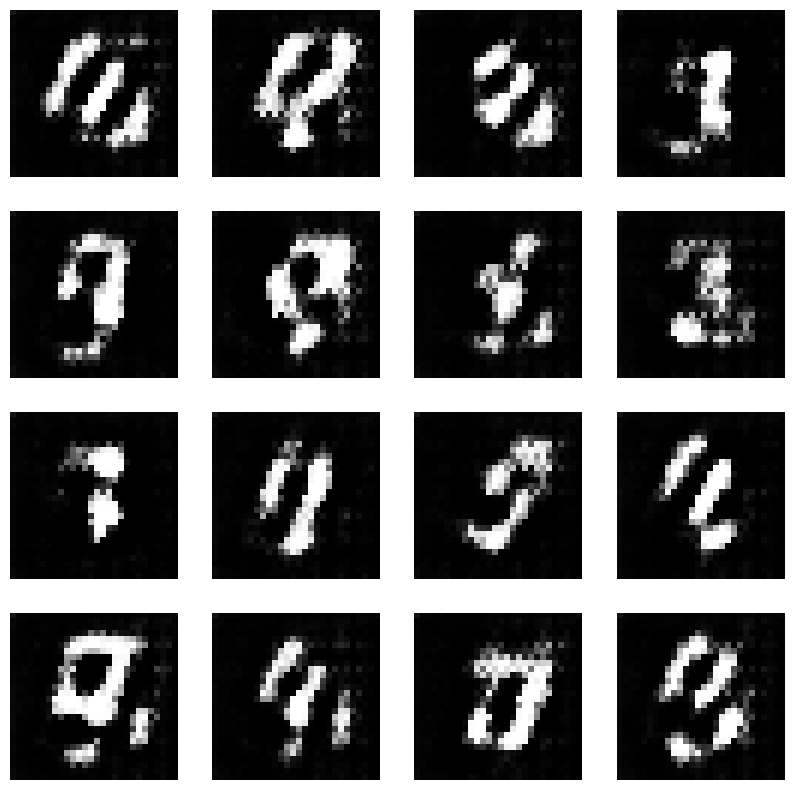

Epoch 14


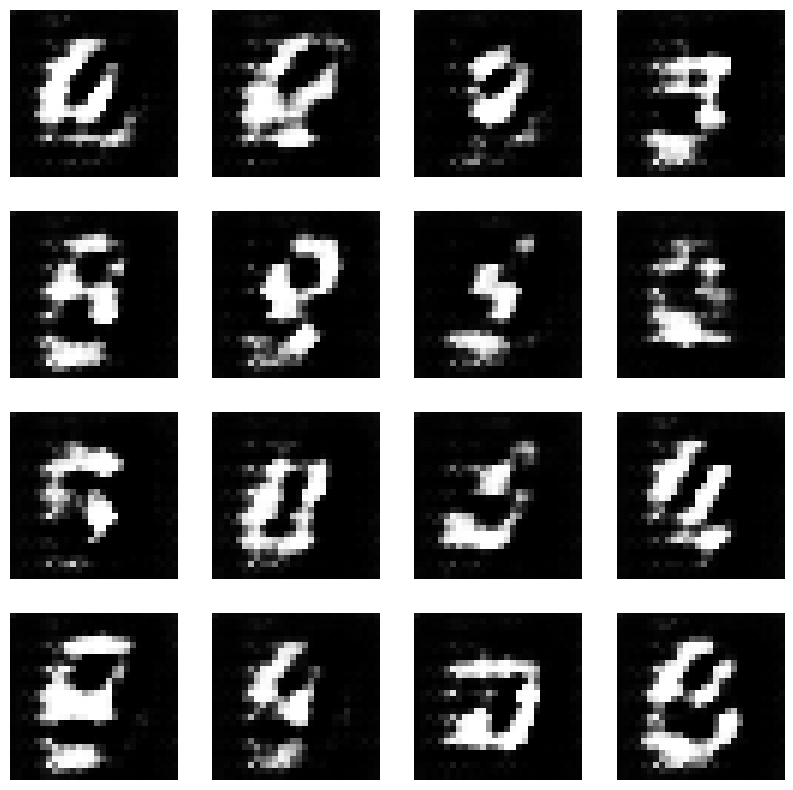

Epoch 15


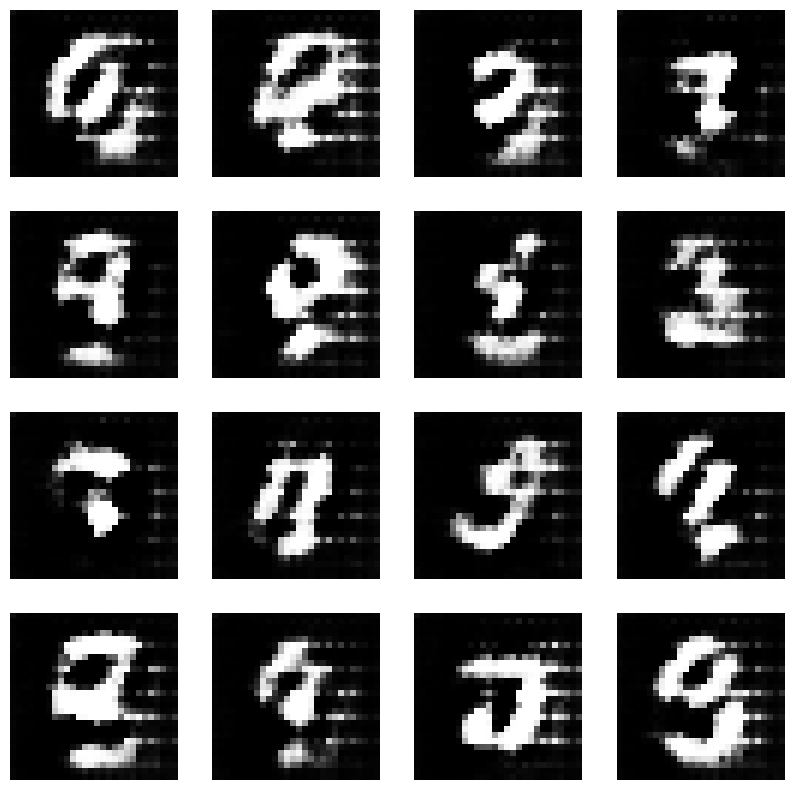

Epoch 16


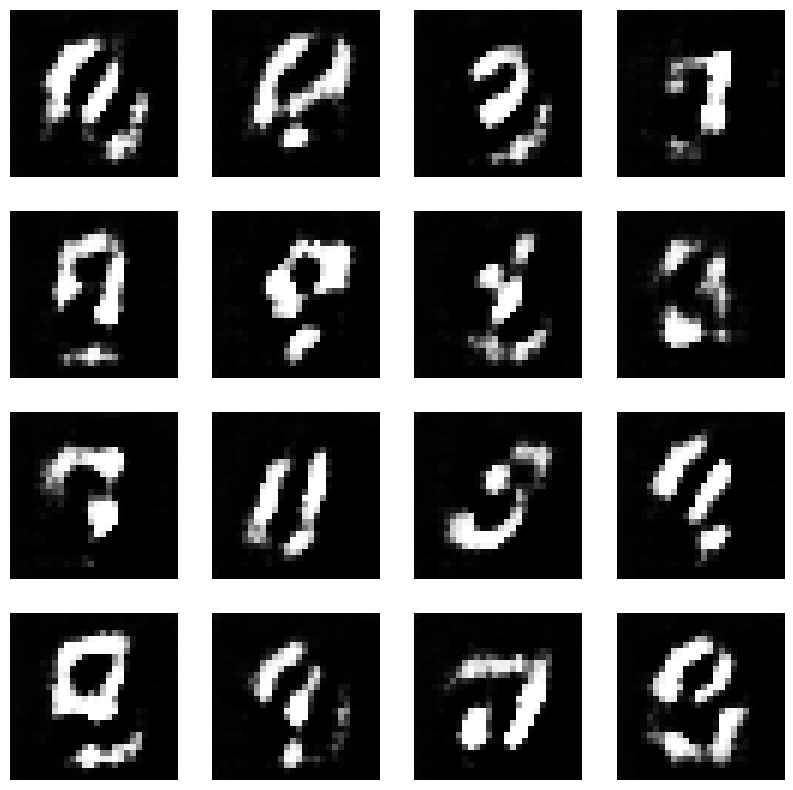

Epoch 17


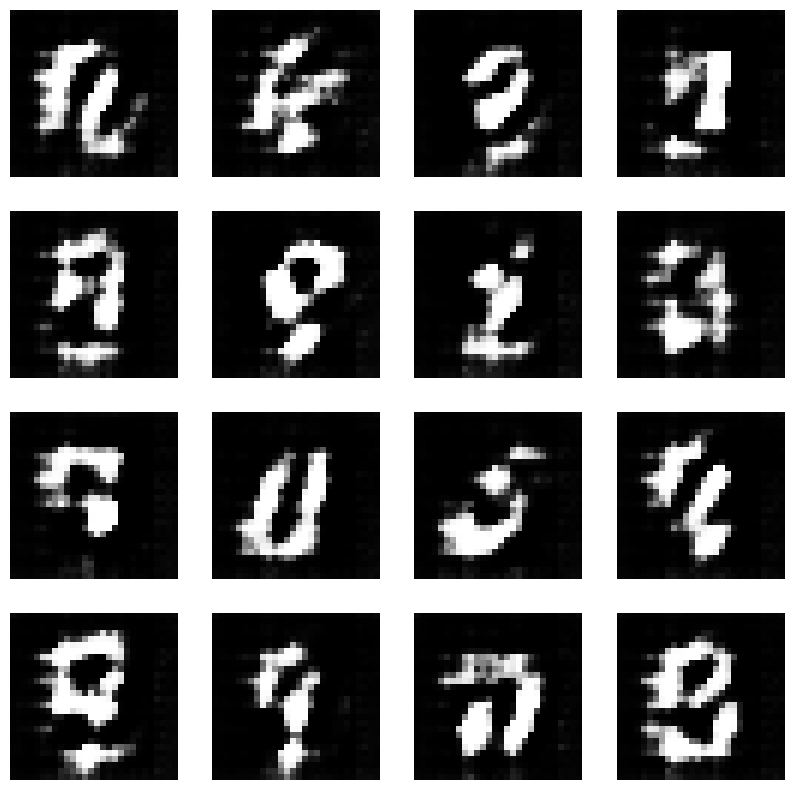

Epoch 18


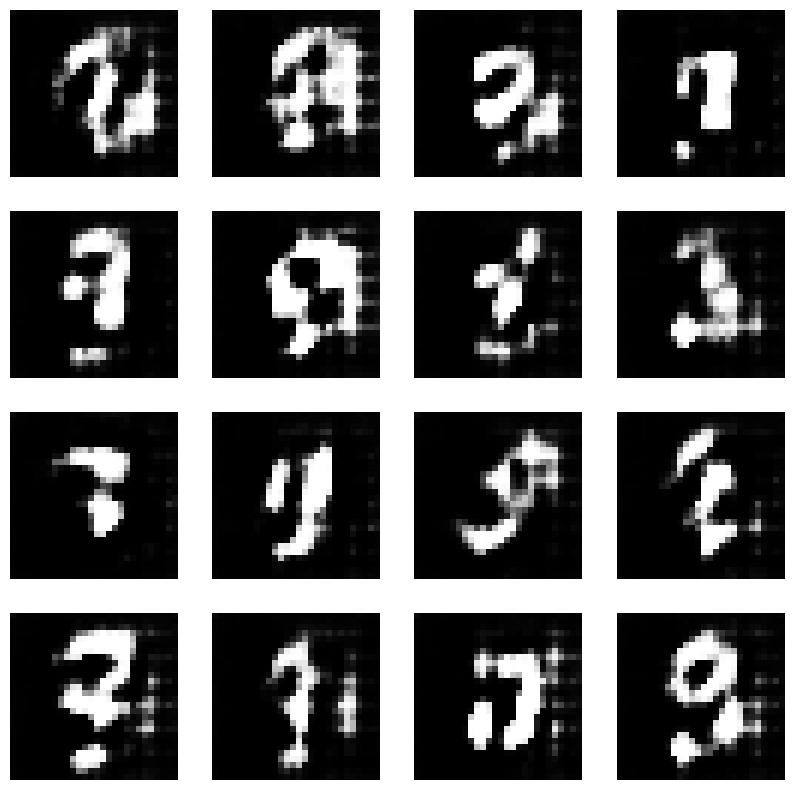

Epoch 19


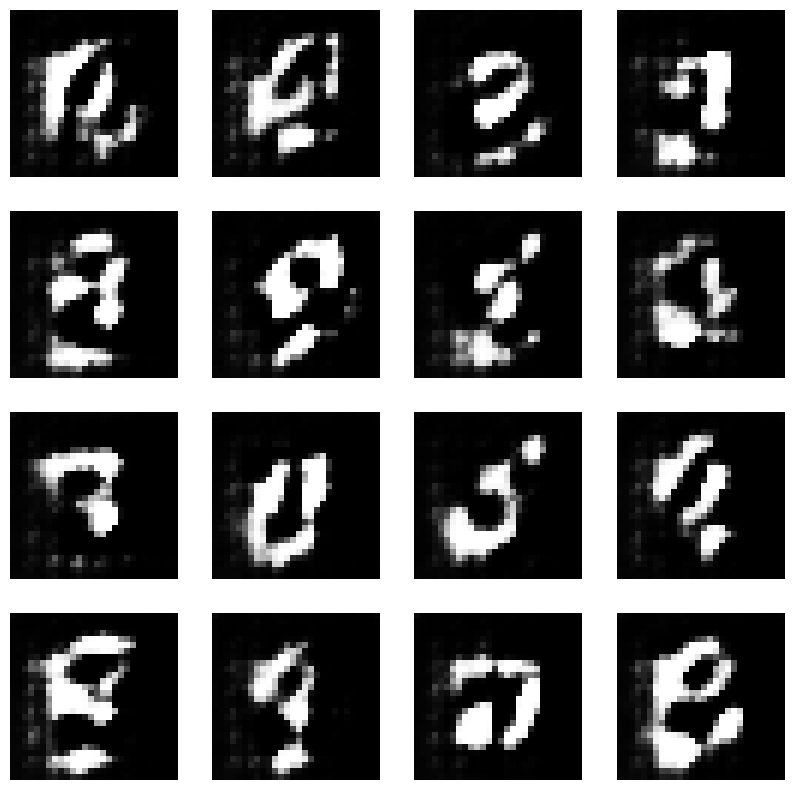

Epoch 20


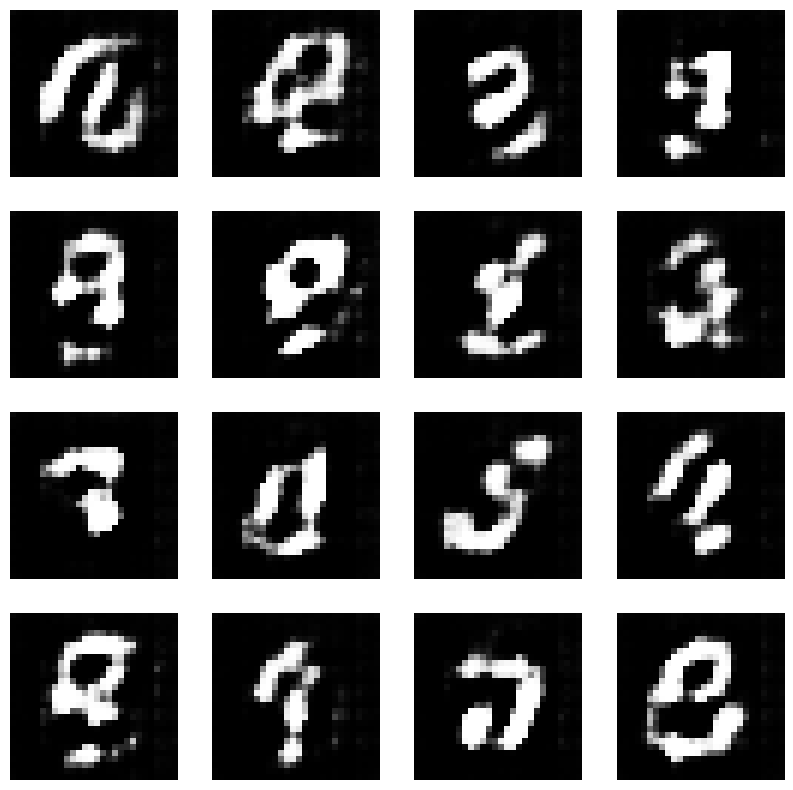

Epoch 21


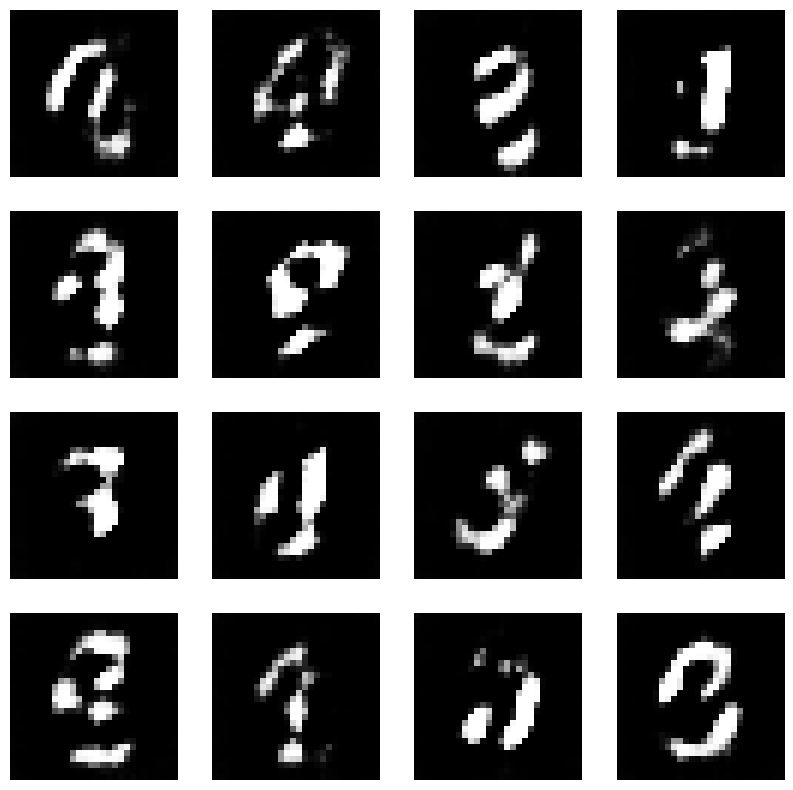

Epoch 22


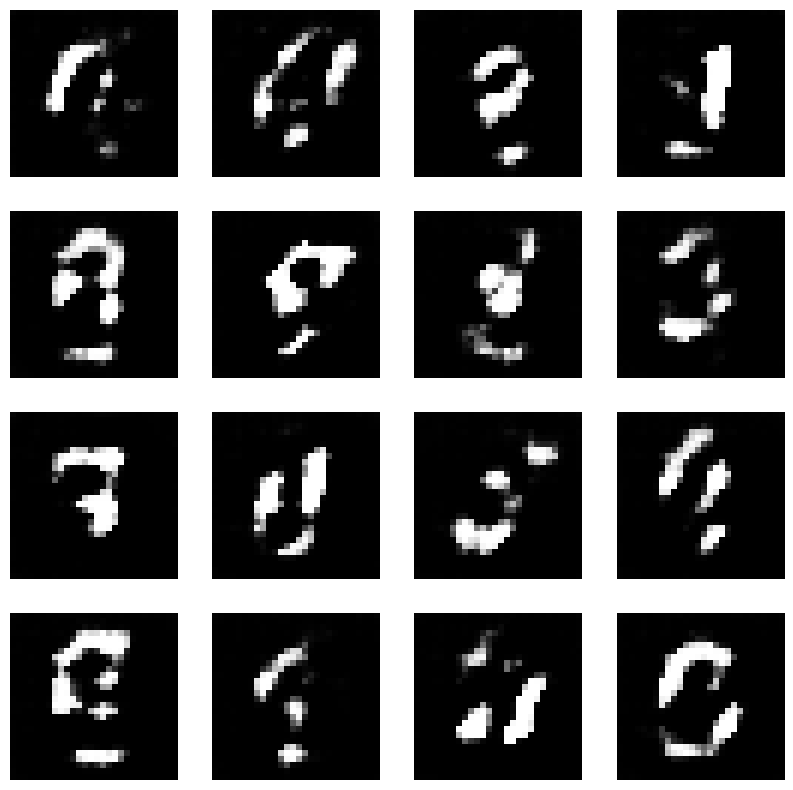

Epoch 23


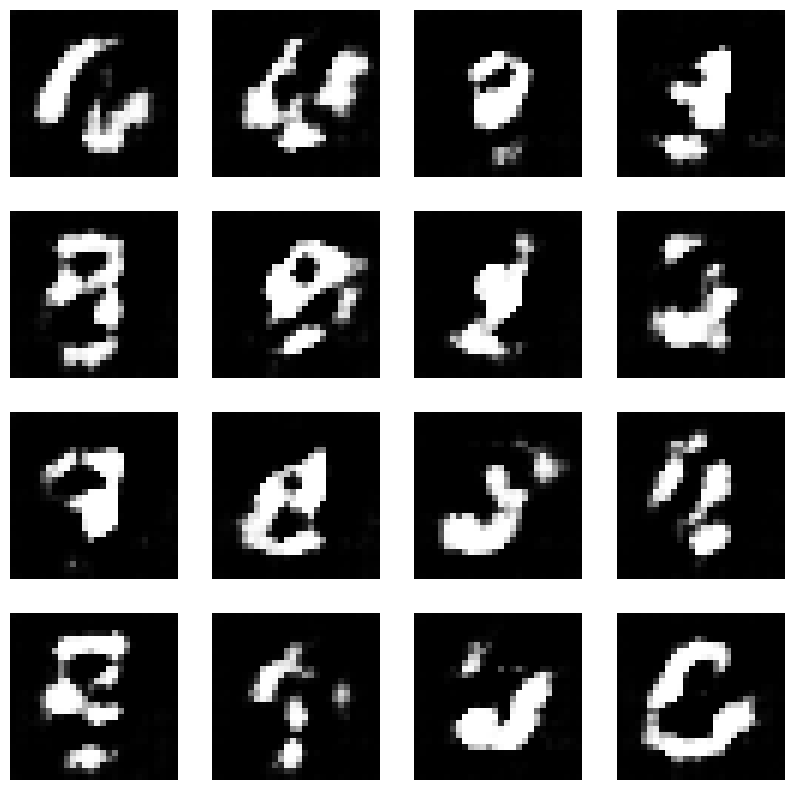

Epoch 24


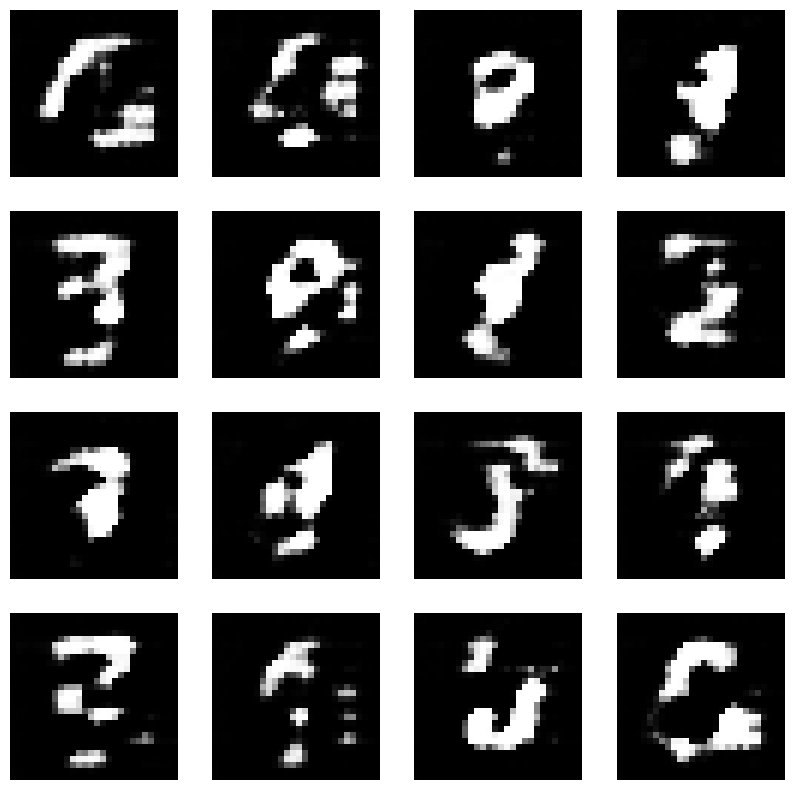

Epoch 25


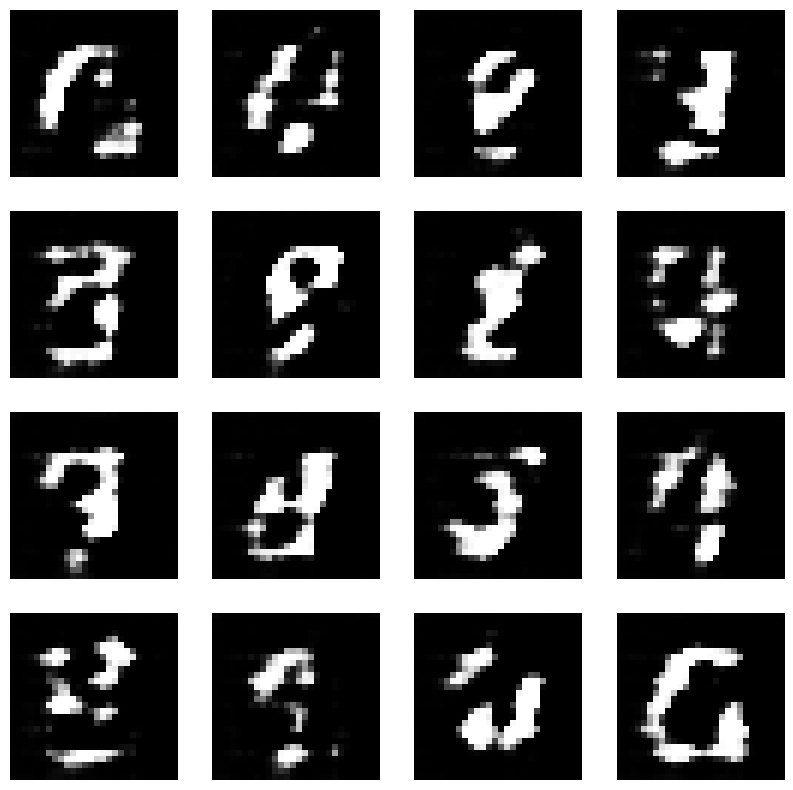

Epoch 26


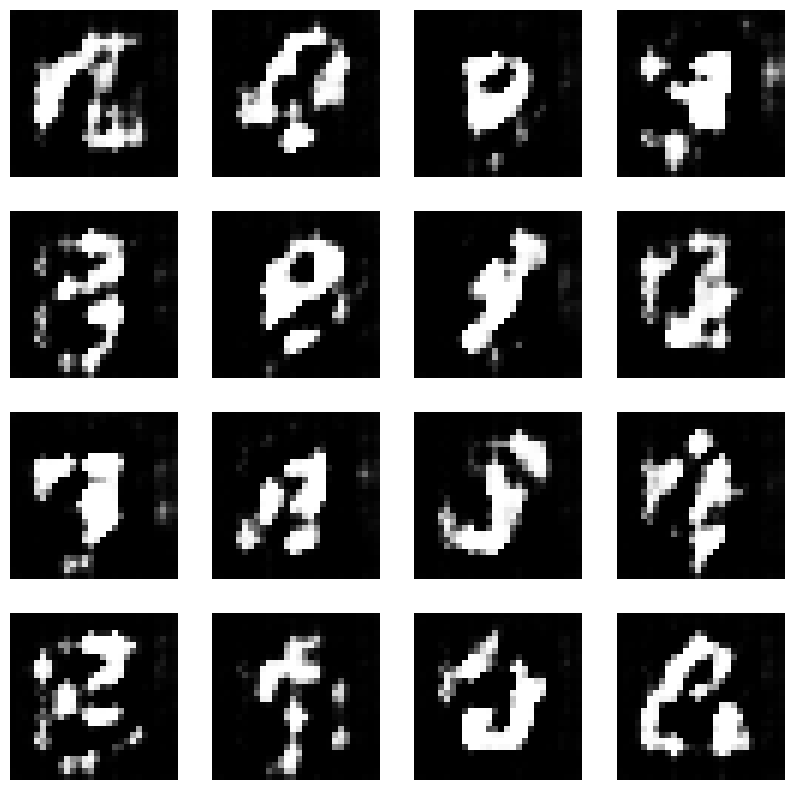

Epoch 27


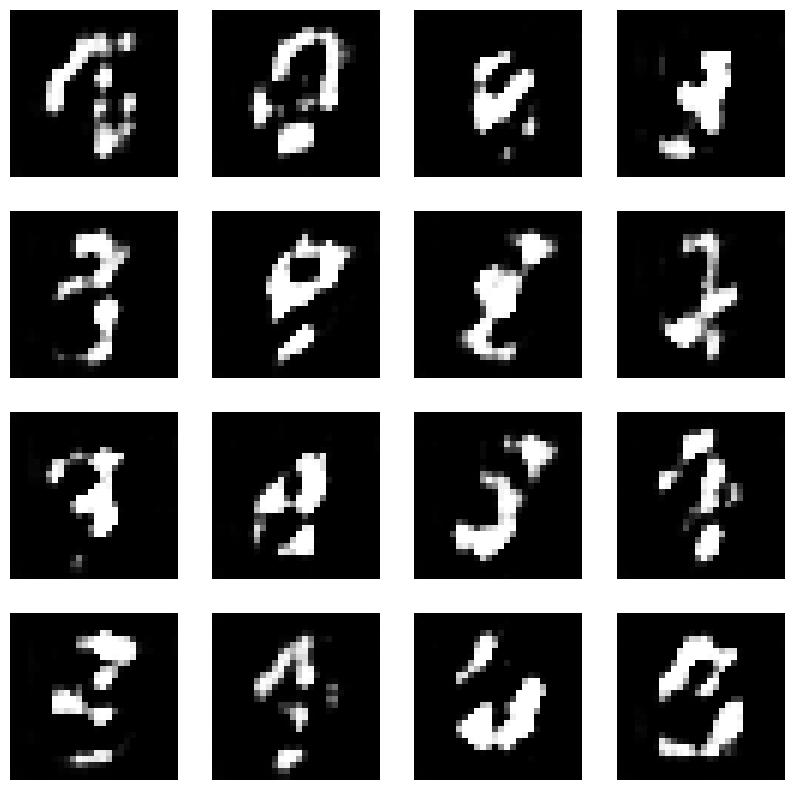

Epoch 28


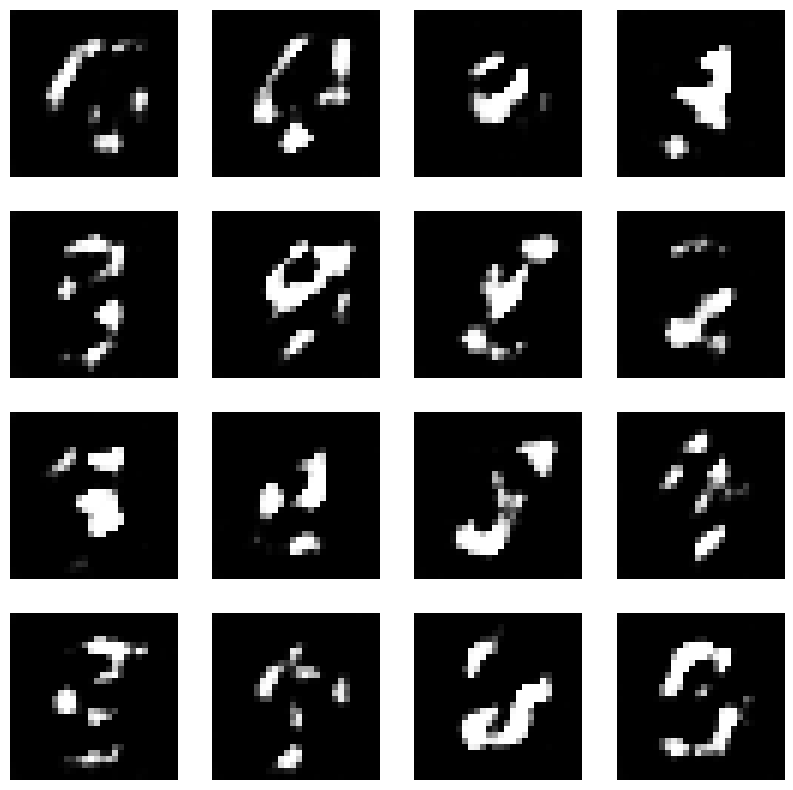

Epoch 29


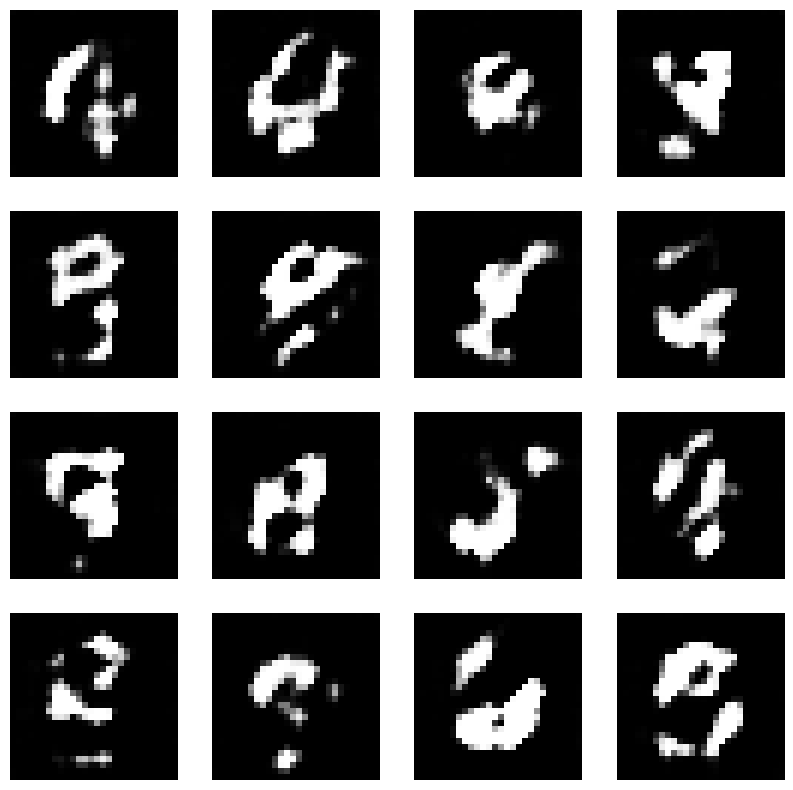

Epoch 30


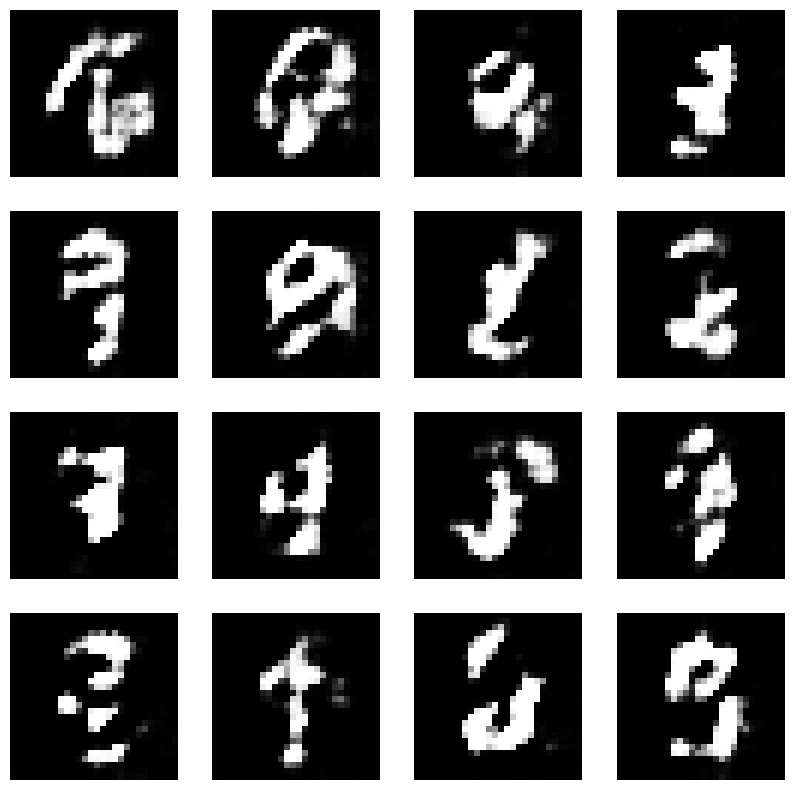

Epoch 31


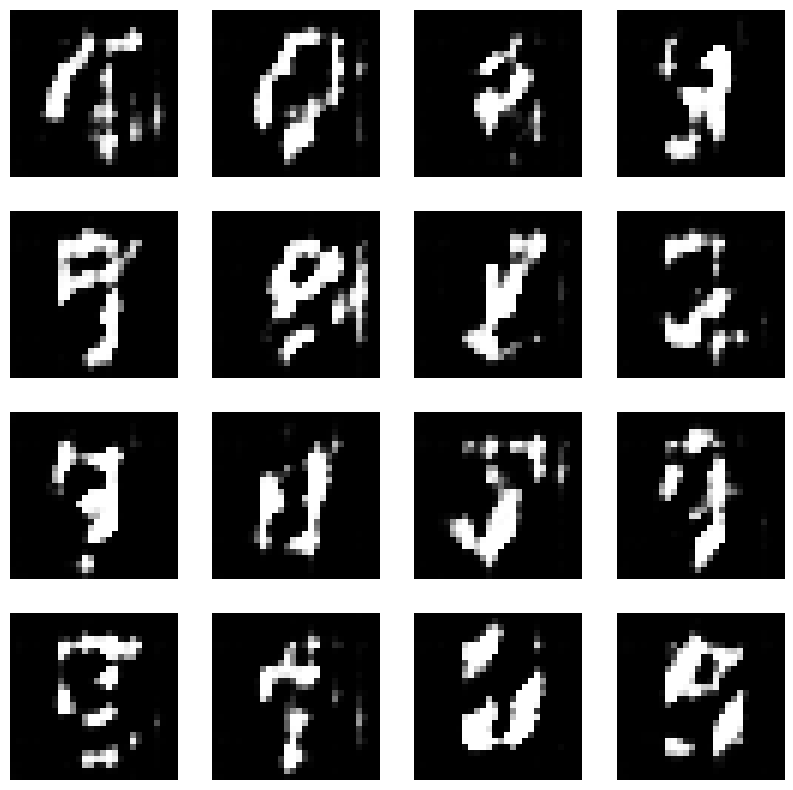

Epoch 32


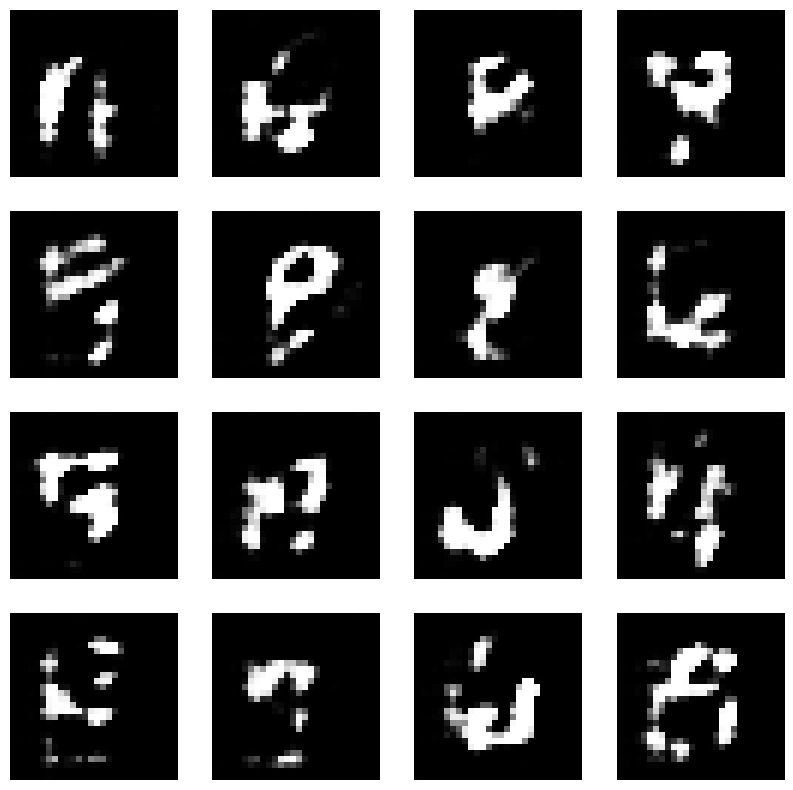

Epoch 33


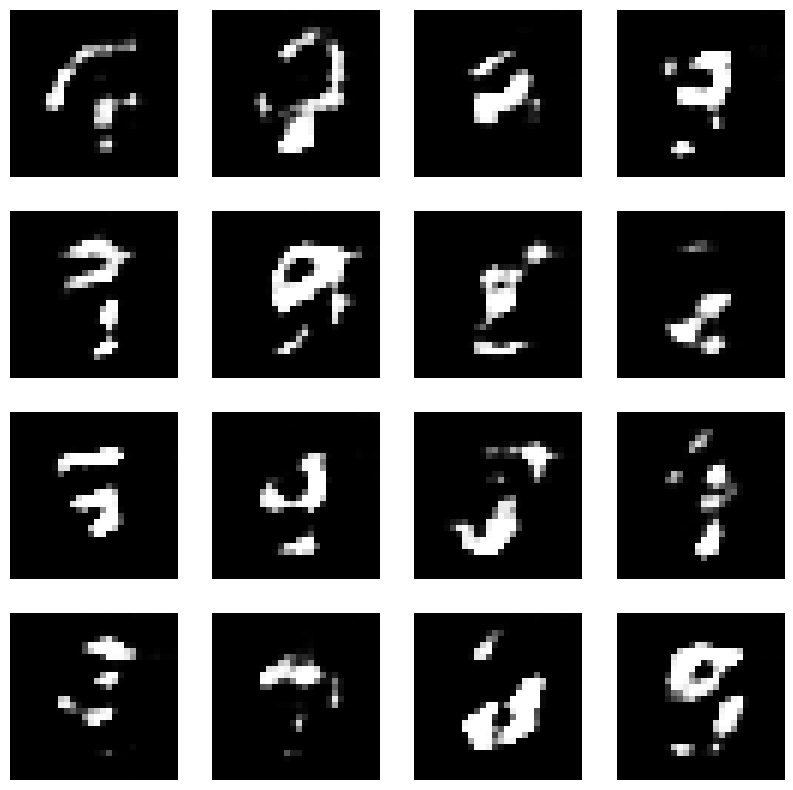

Epoch 34


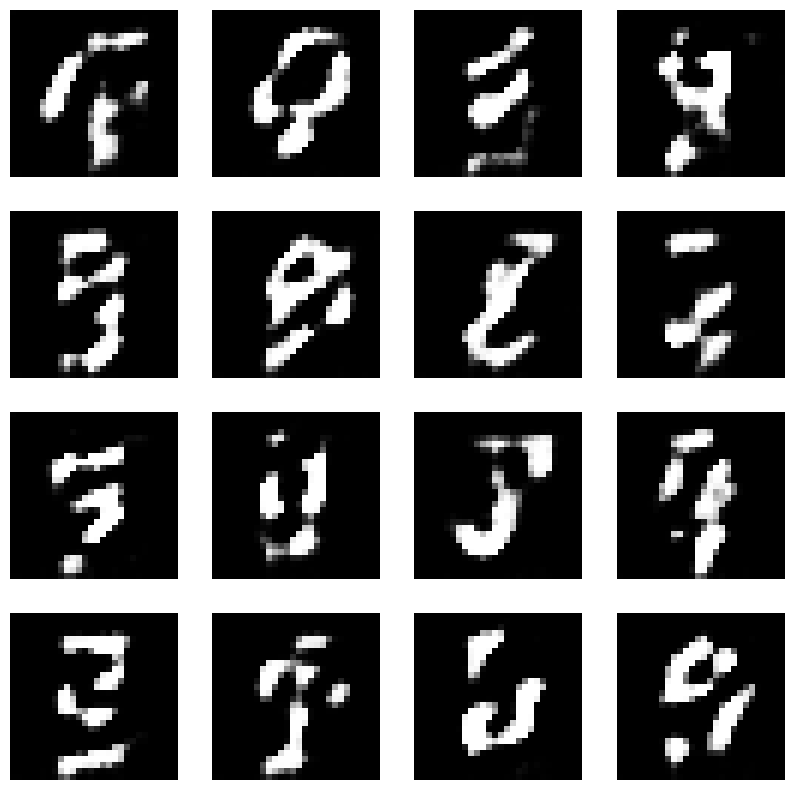

Epoch 35


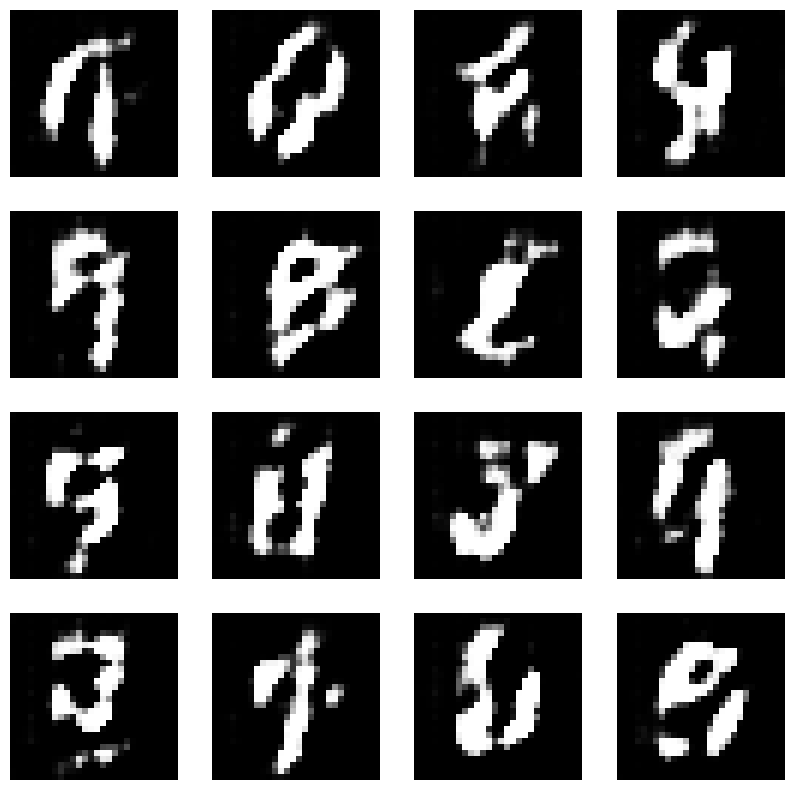

Epoch 36


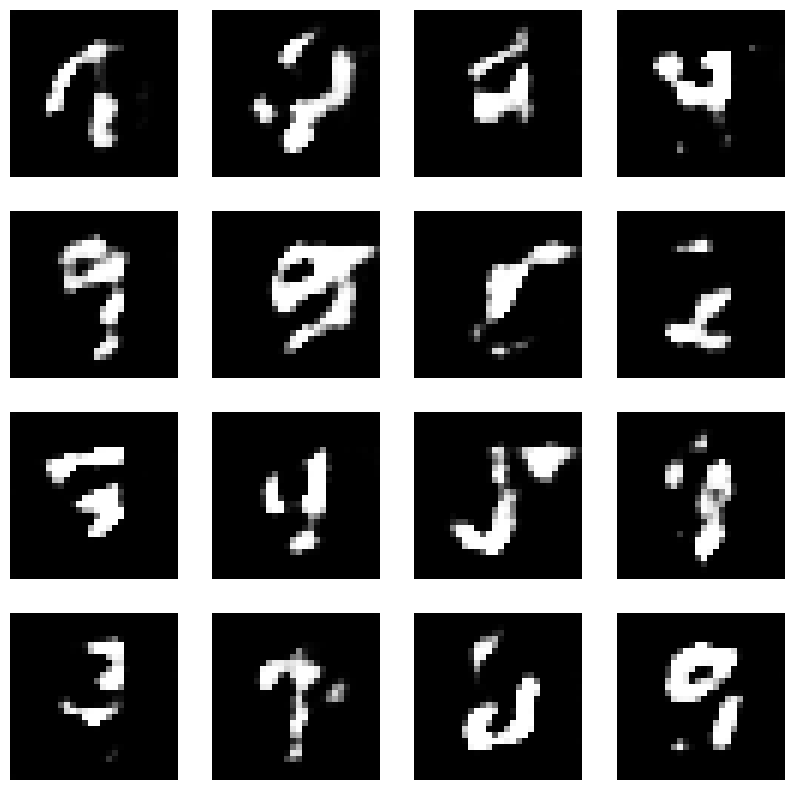

Epoch 37


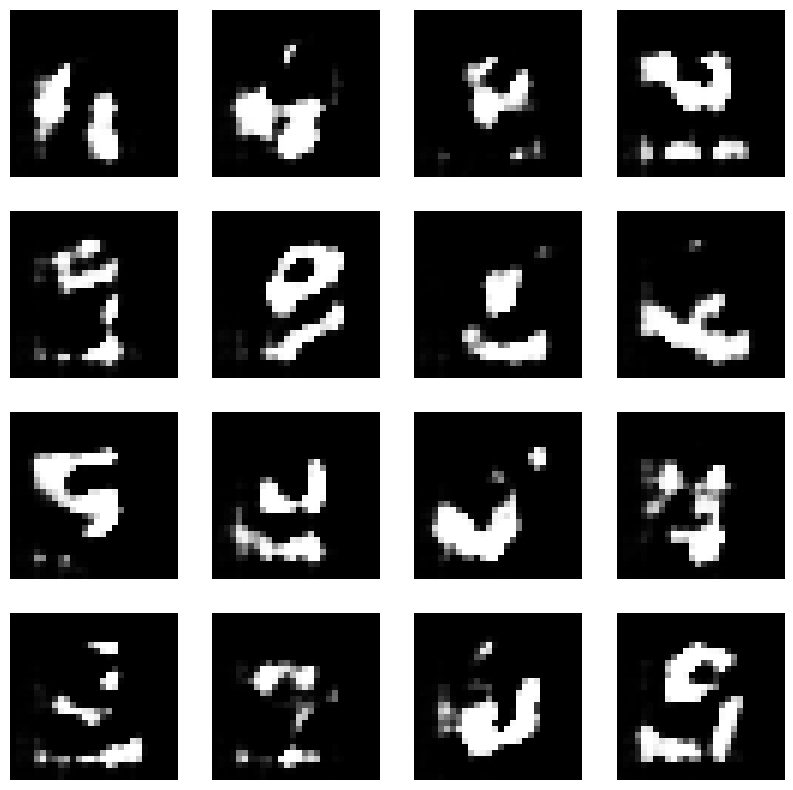

Epoch 38


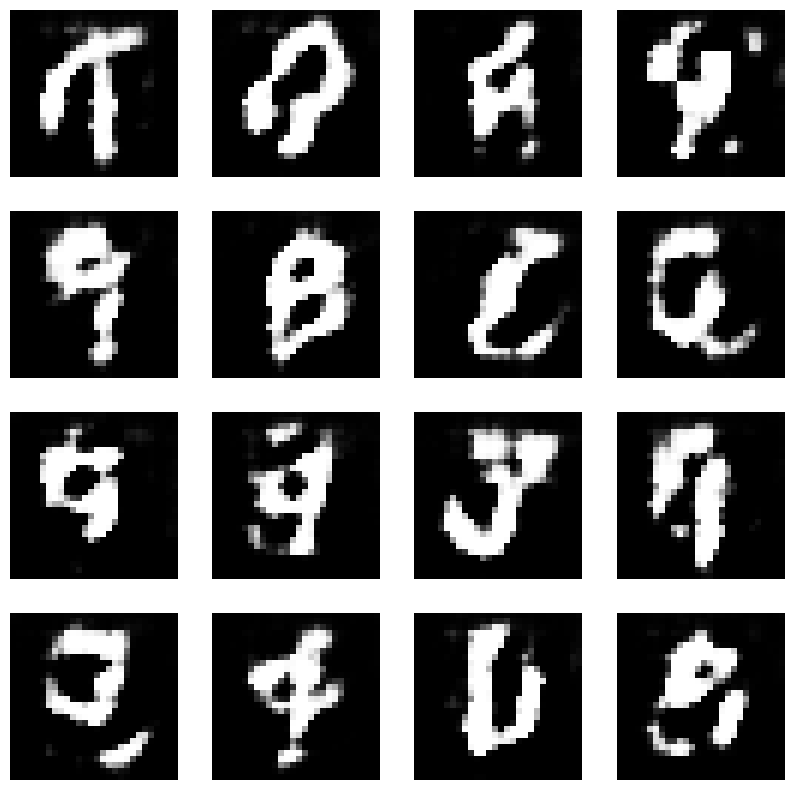

Epoch 39


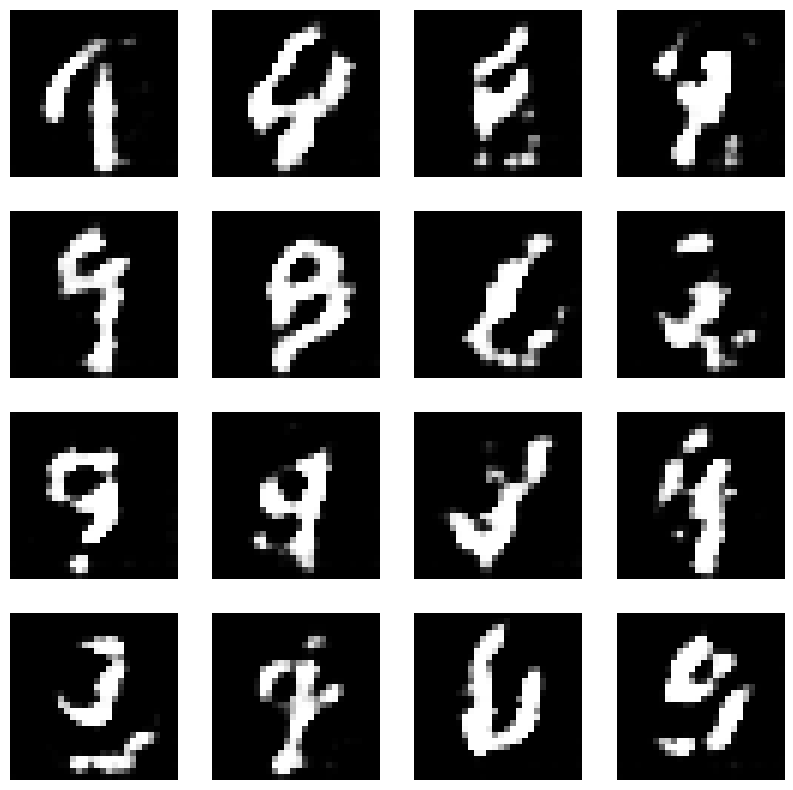

Epoch 40


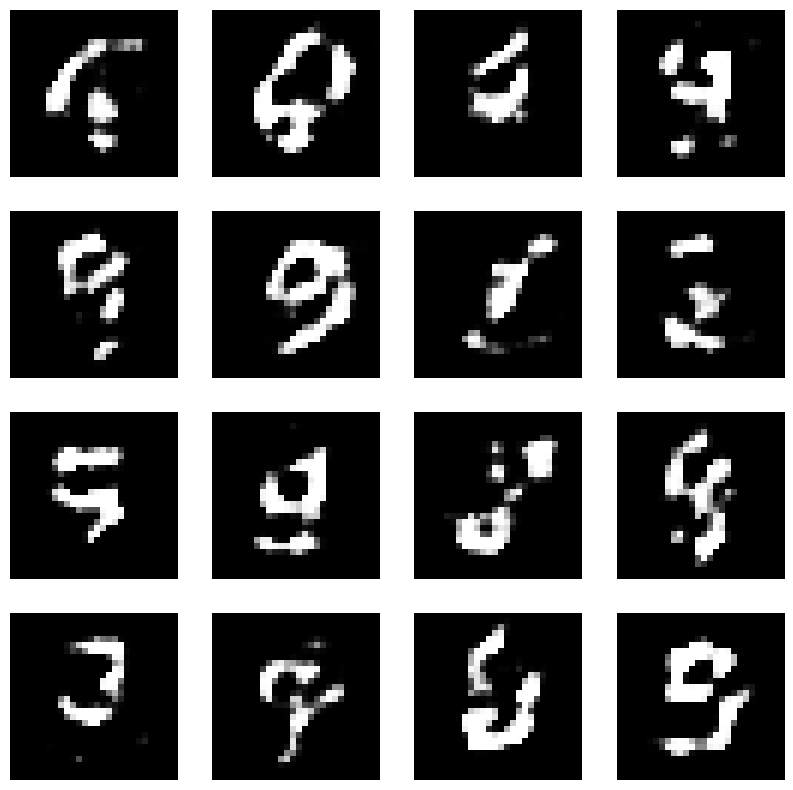

Epoch 41


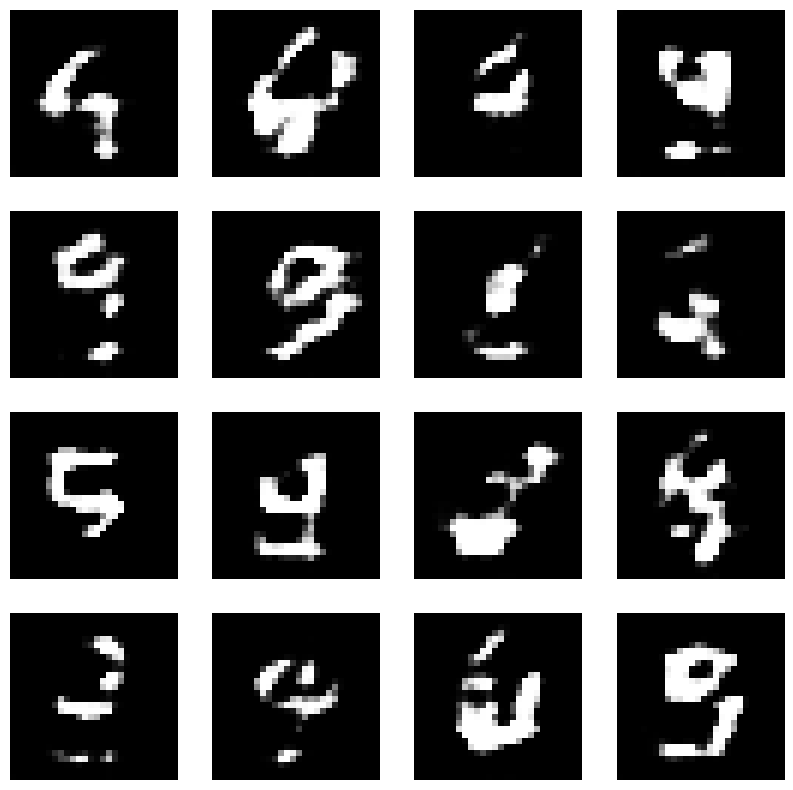

Epoch 42


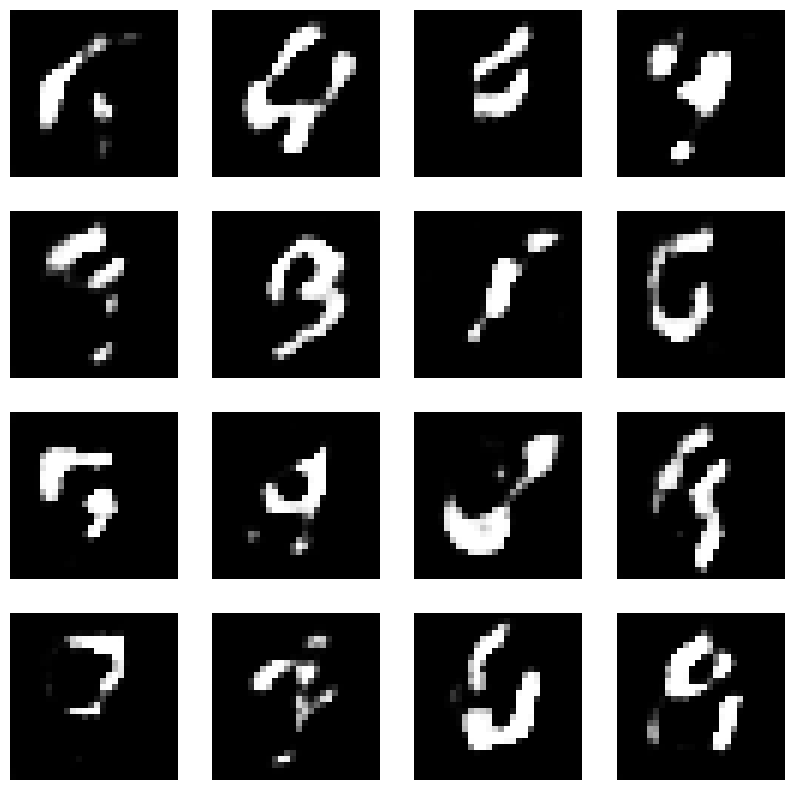

Epoch 43


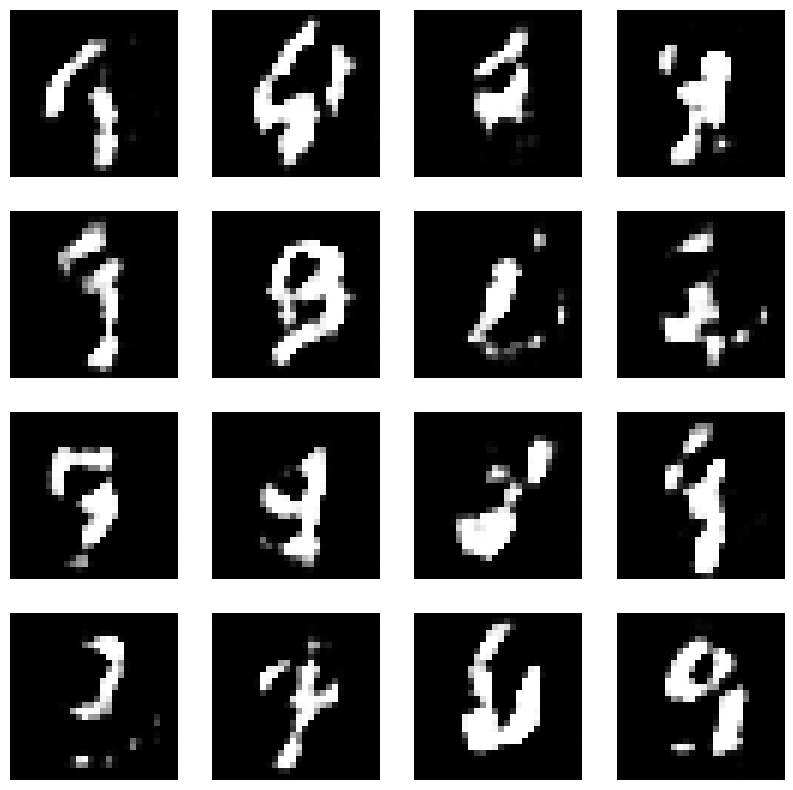

Epoch 44


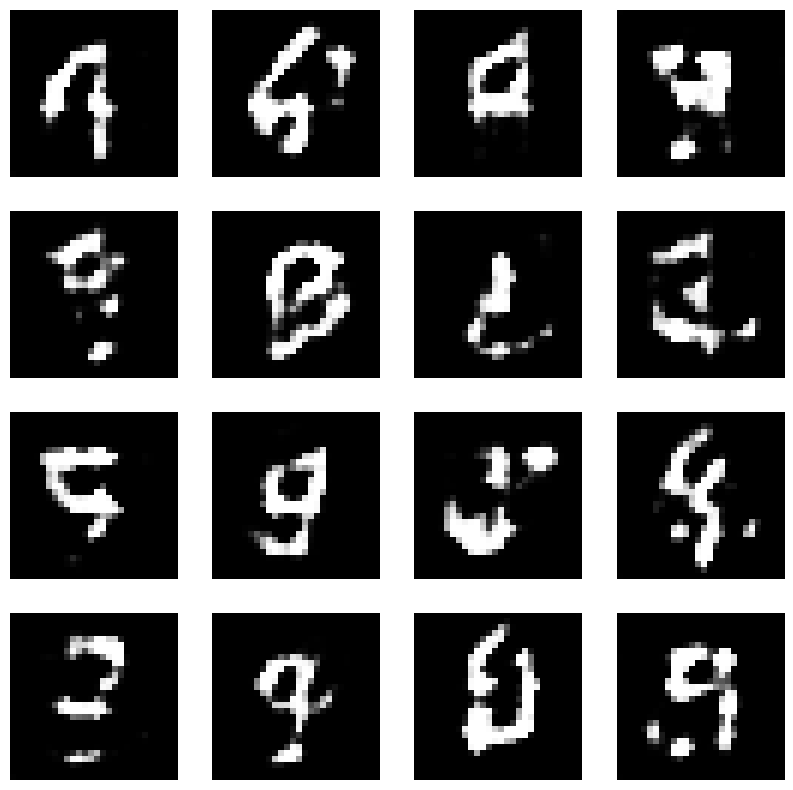

Epoch 45


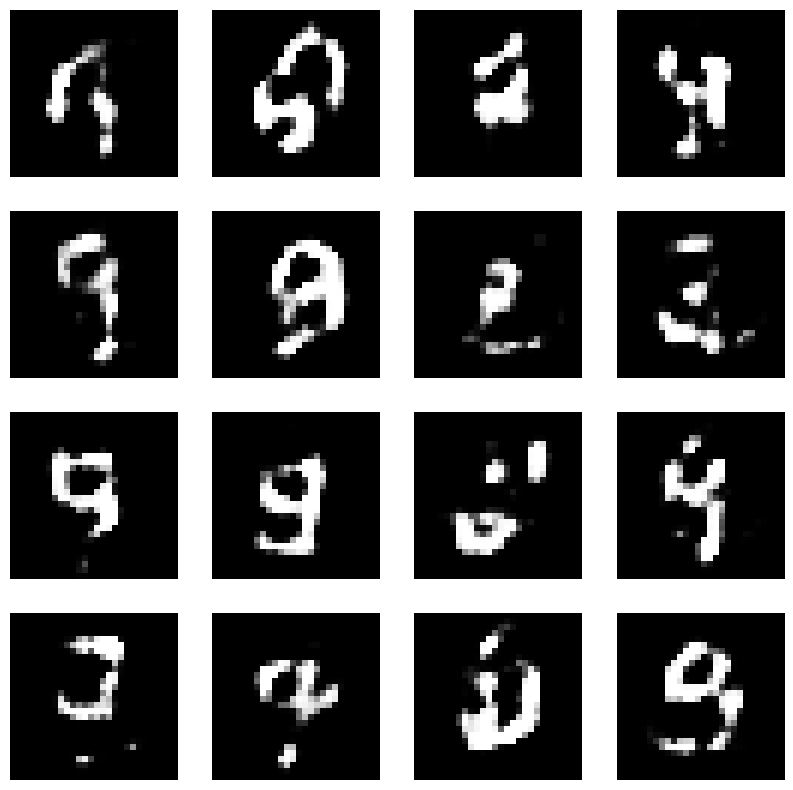

Epoch 46


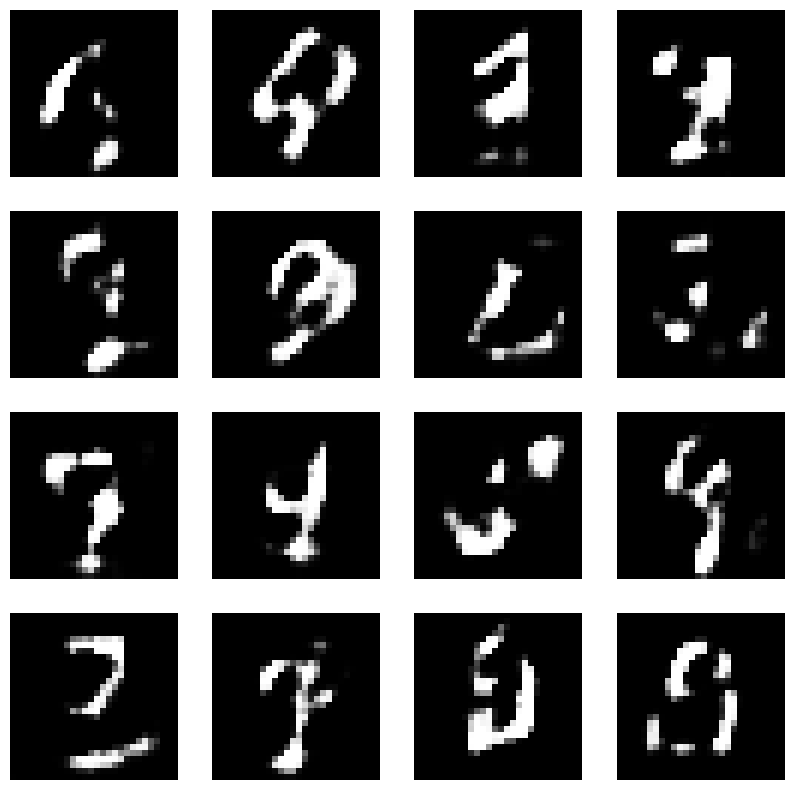

Epoch 47


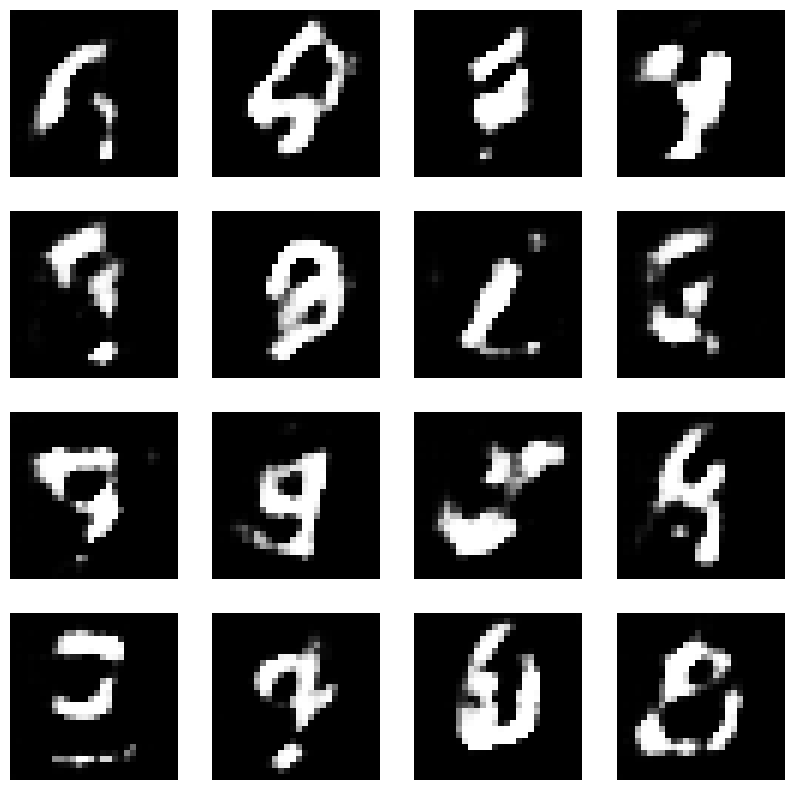

Epoch 48


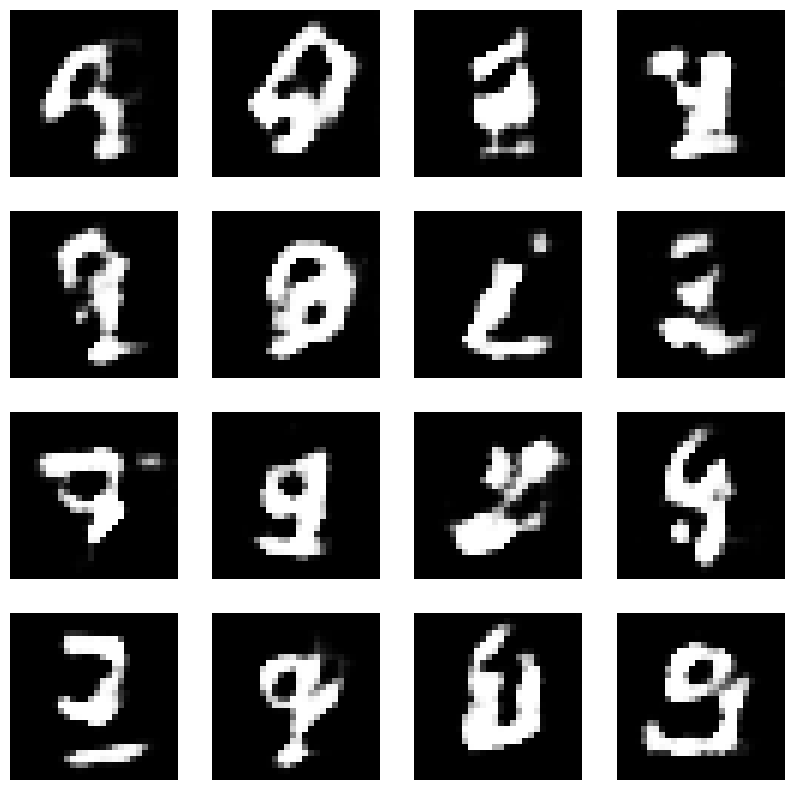

Epoch 49


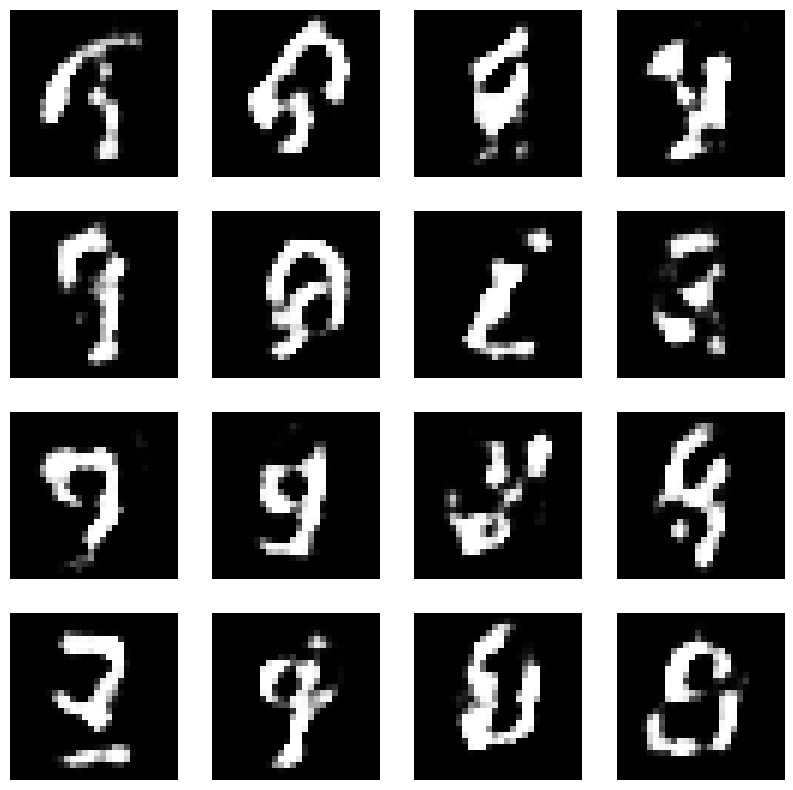

Epoch 50


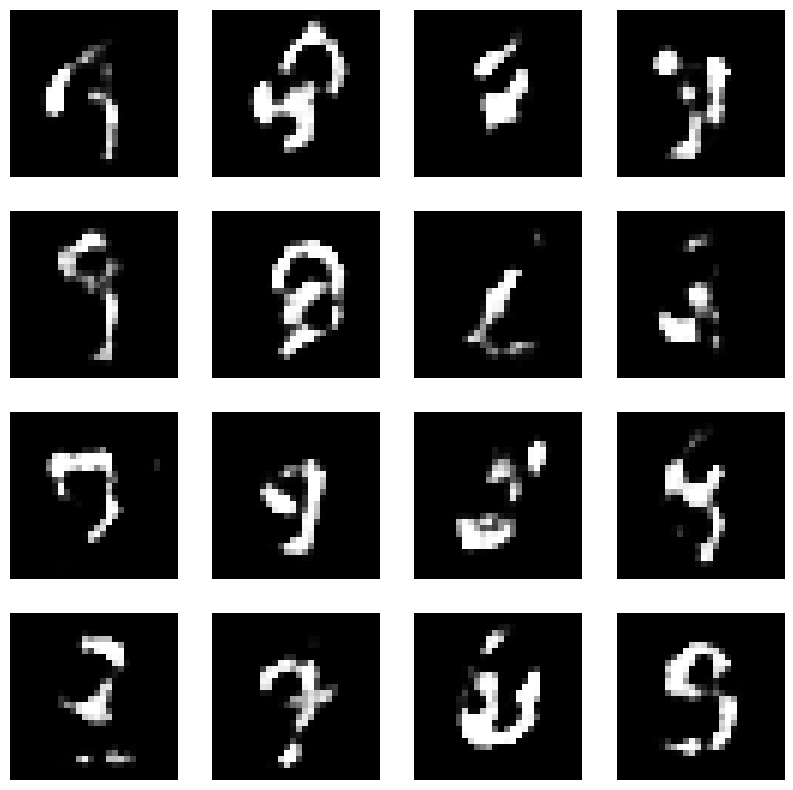

Epoch 51


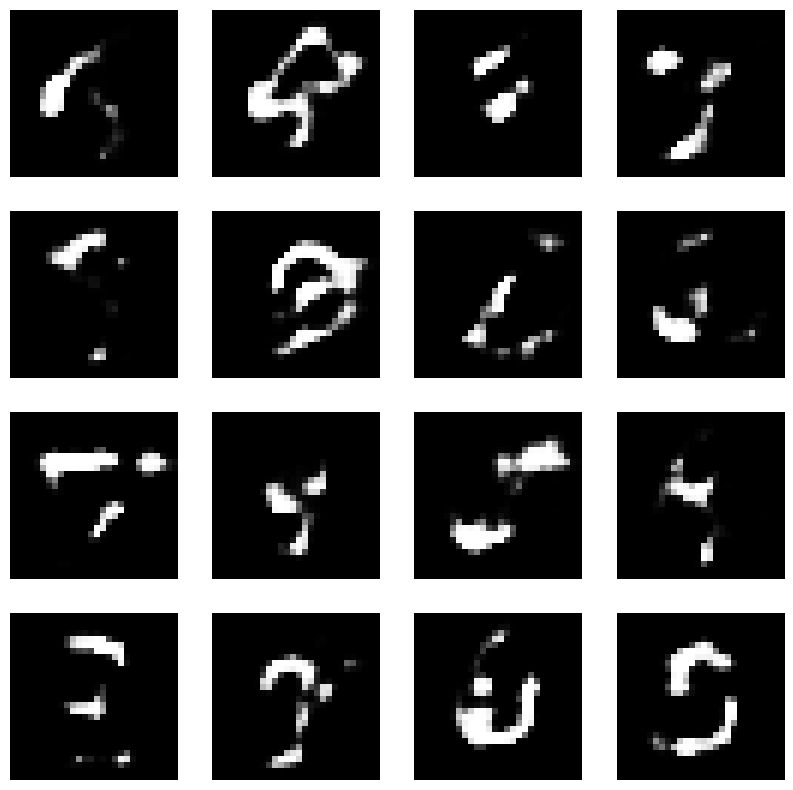

Epoch 52


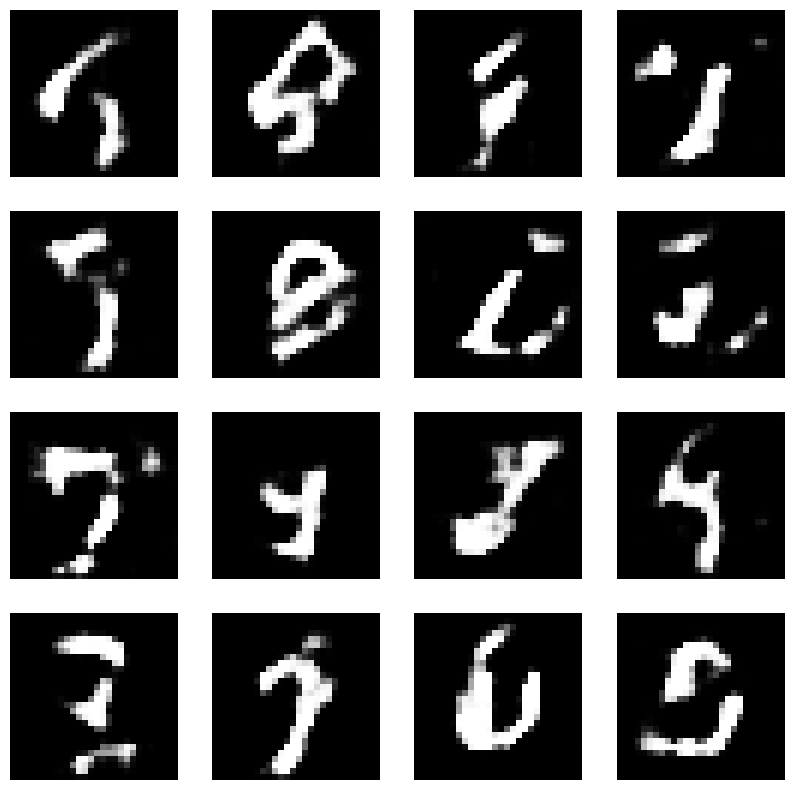

Epoch 53


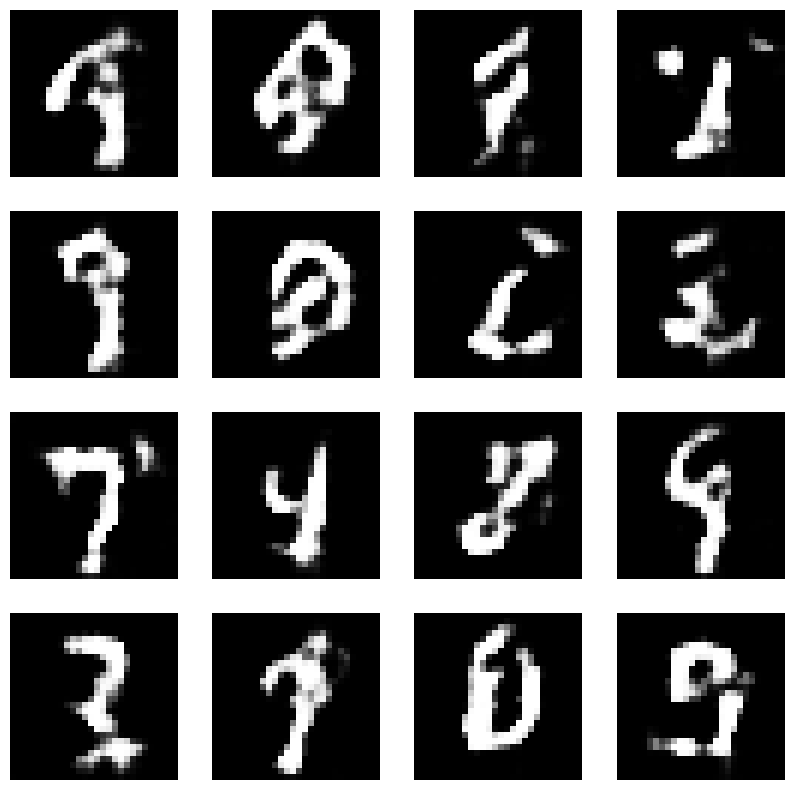

Epoch 54


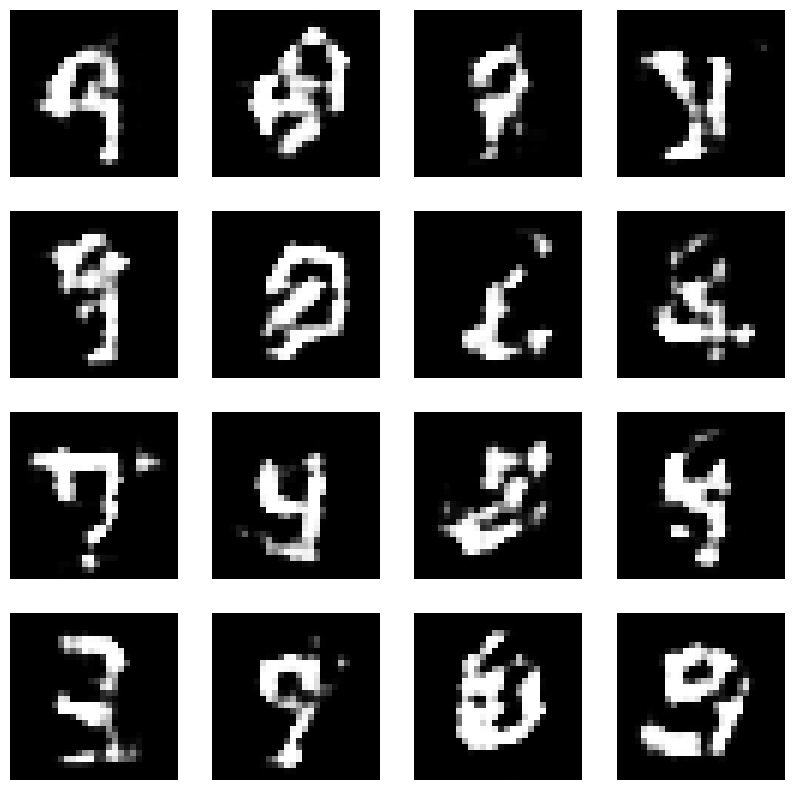

Epoch 55


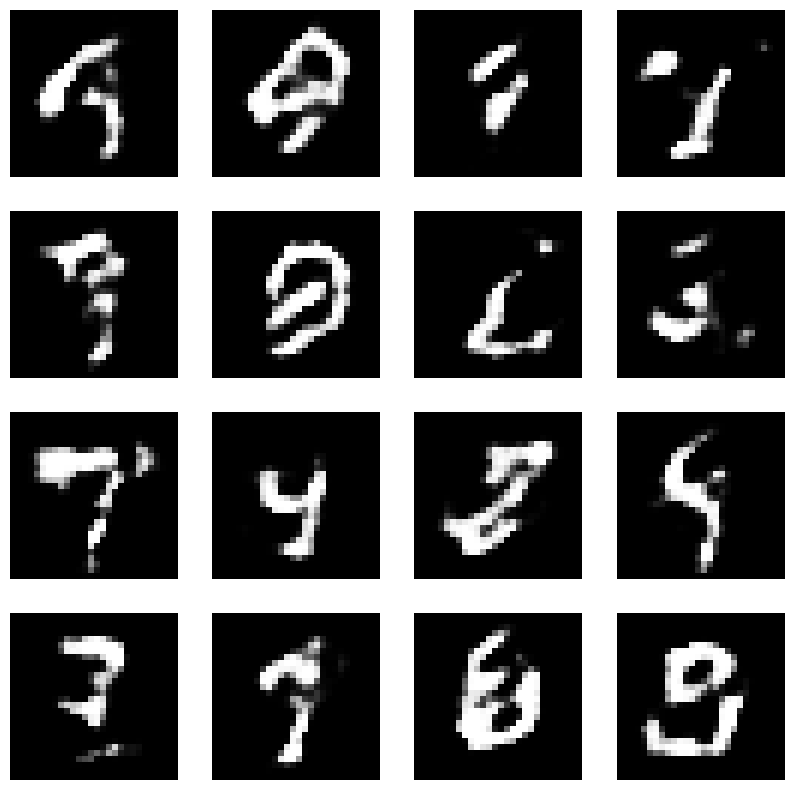

Epoch 56


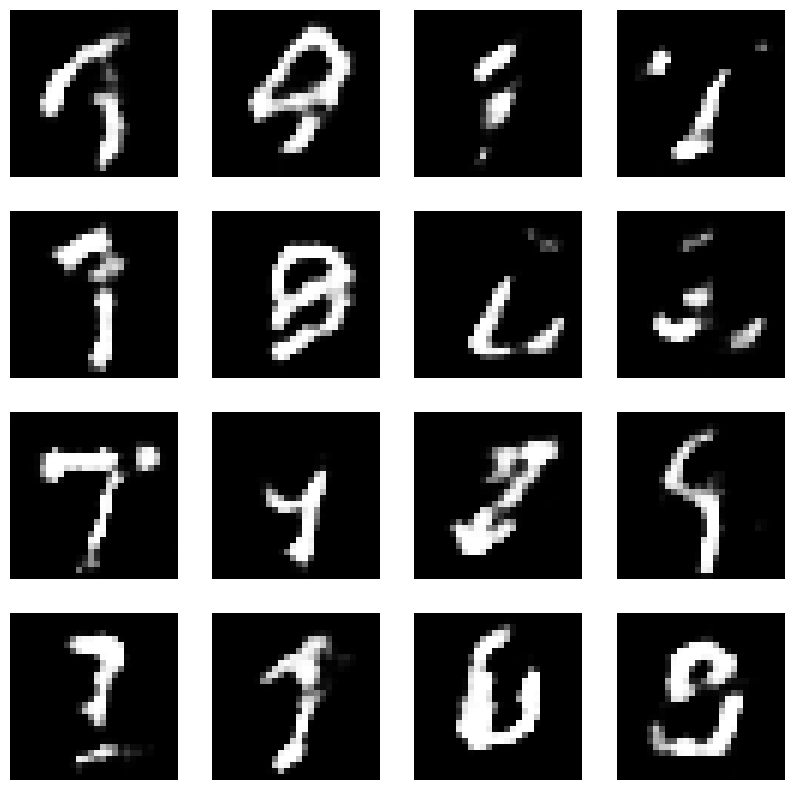

Epoch 57


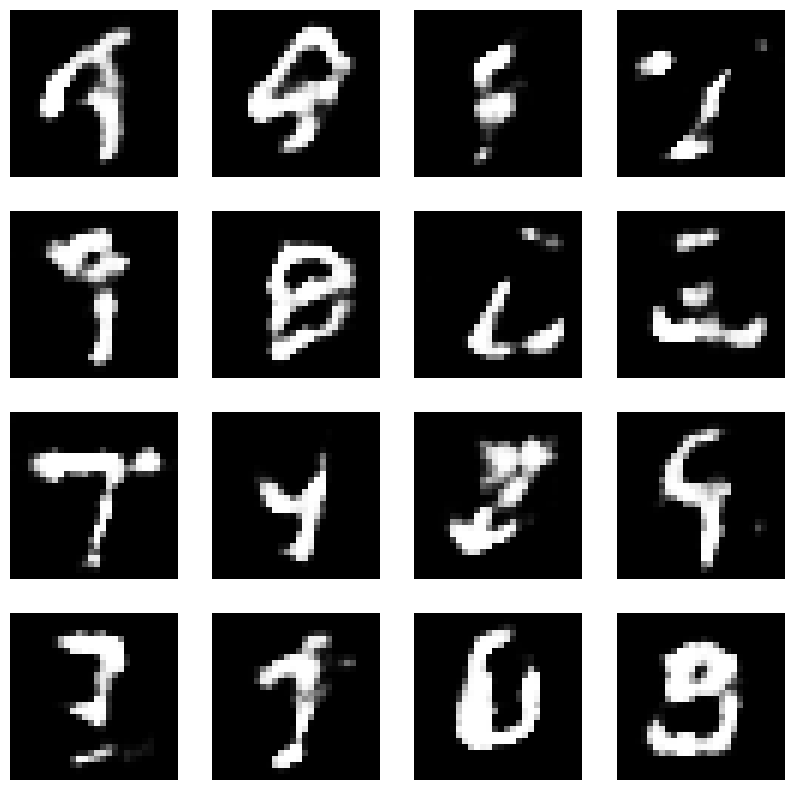

Epoch 58


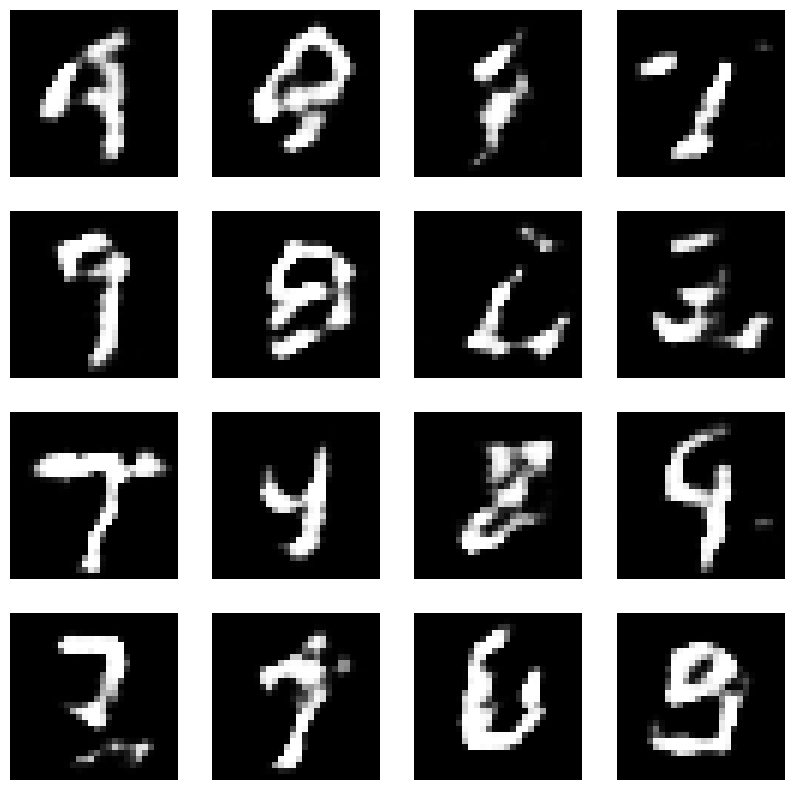

Epoch 59


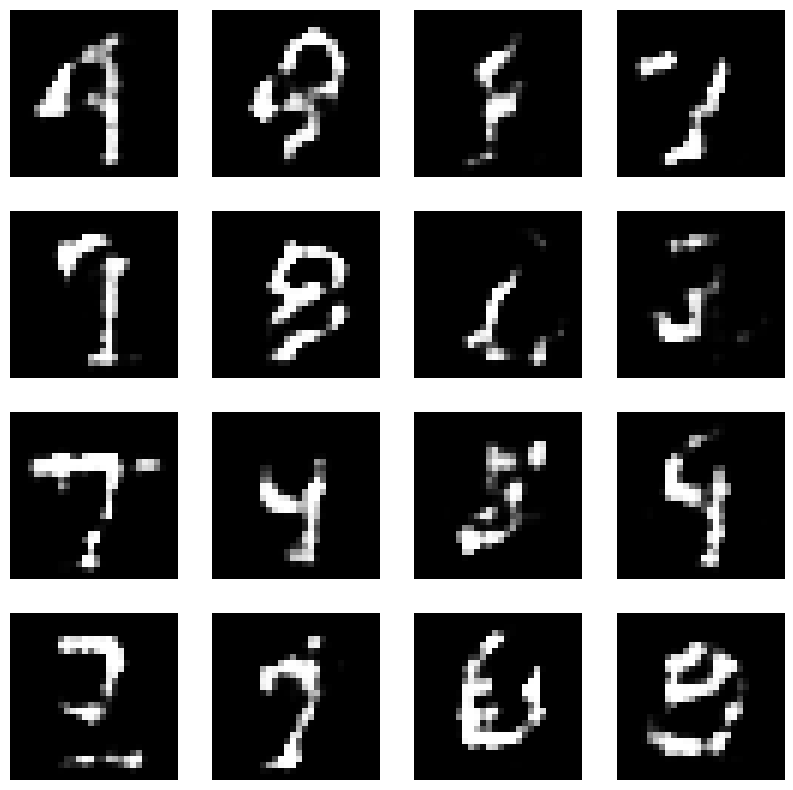

Epoch 60


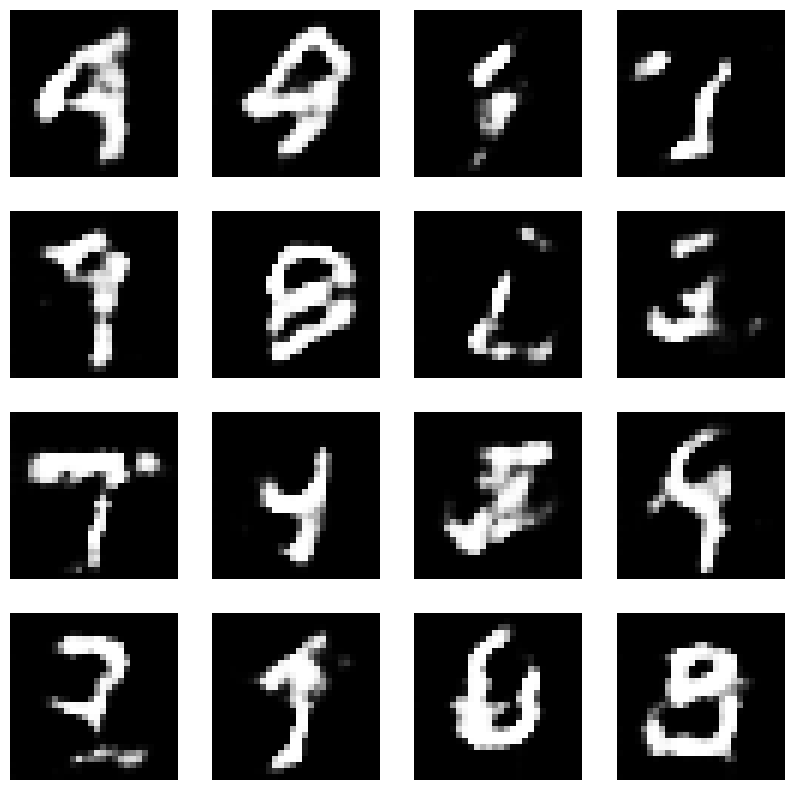

Epoch 61


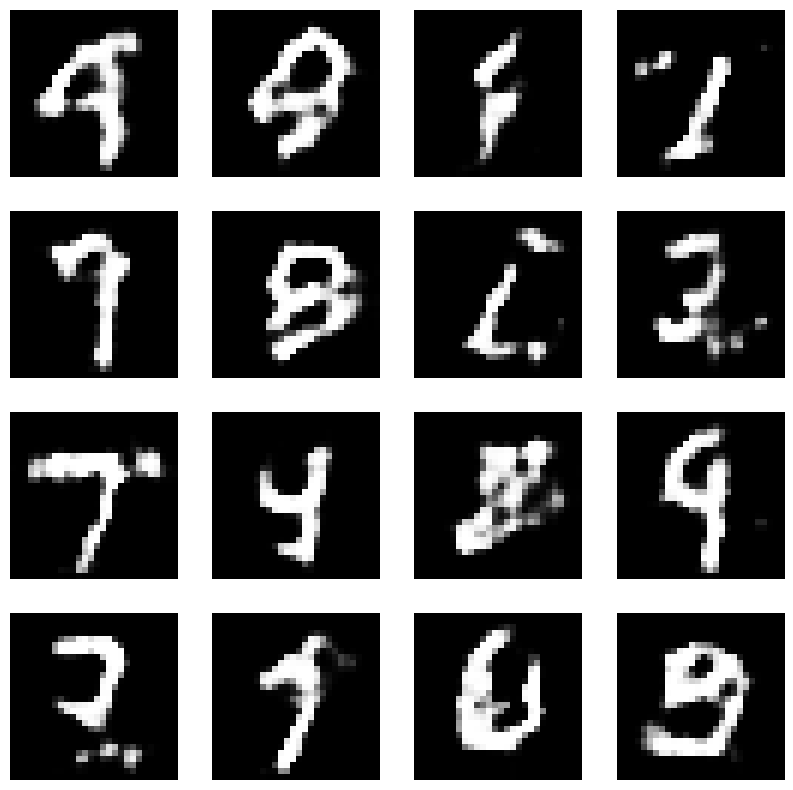

Epoch 62


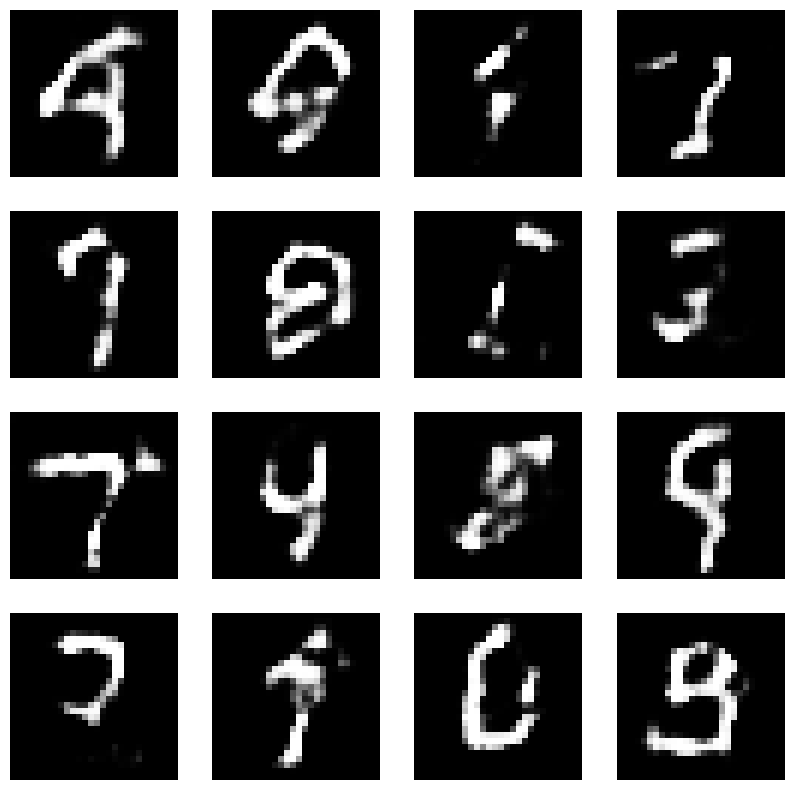

Epoch 63


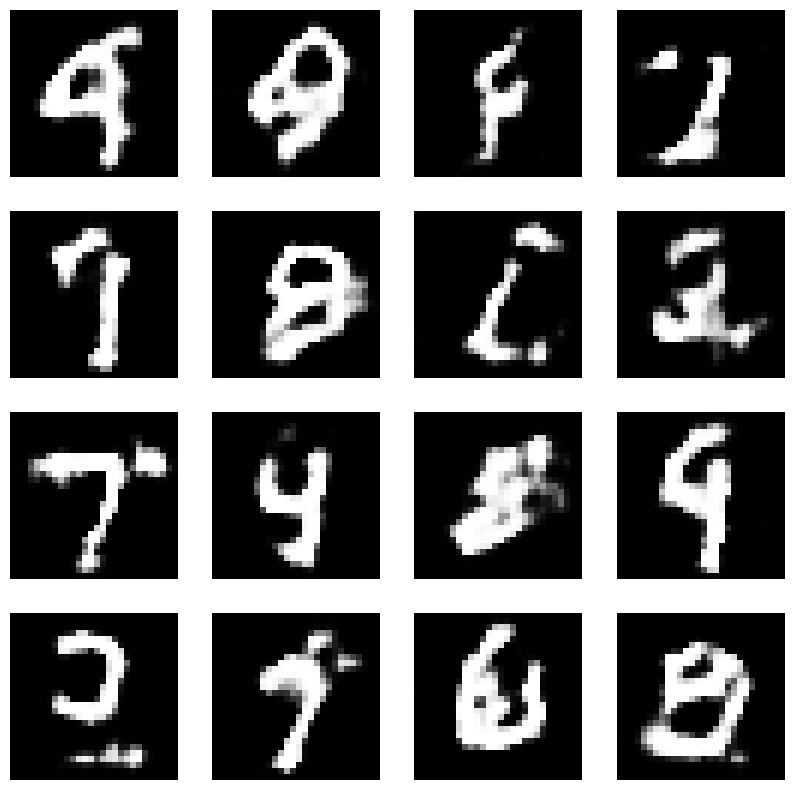

Epoch 64


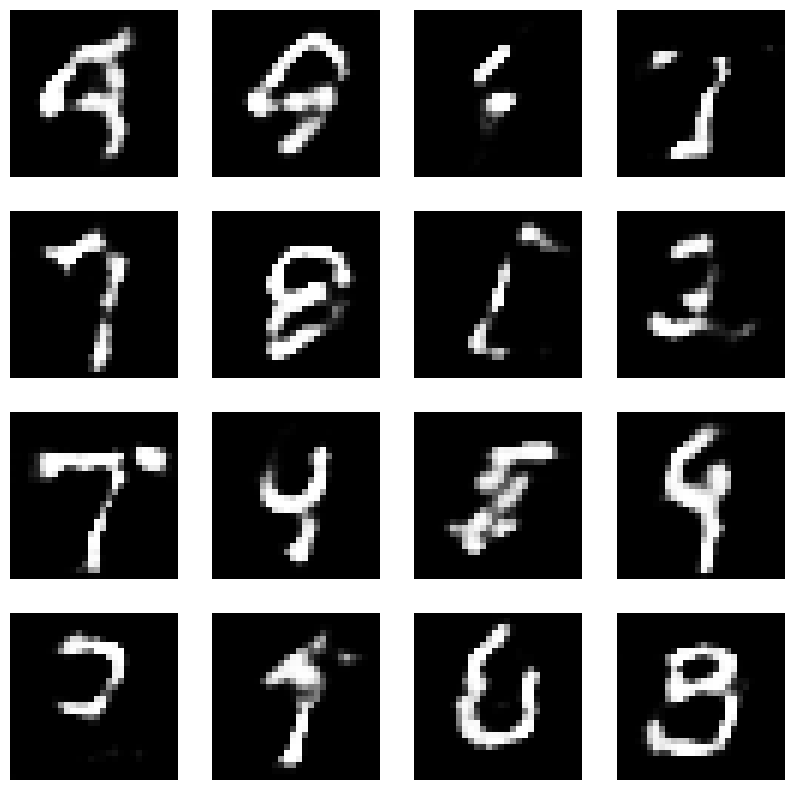

Epoch 65


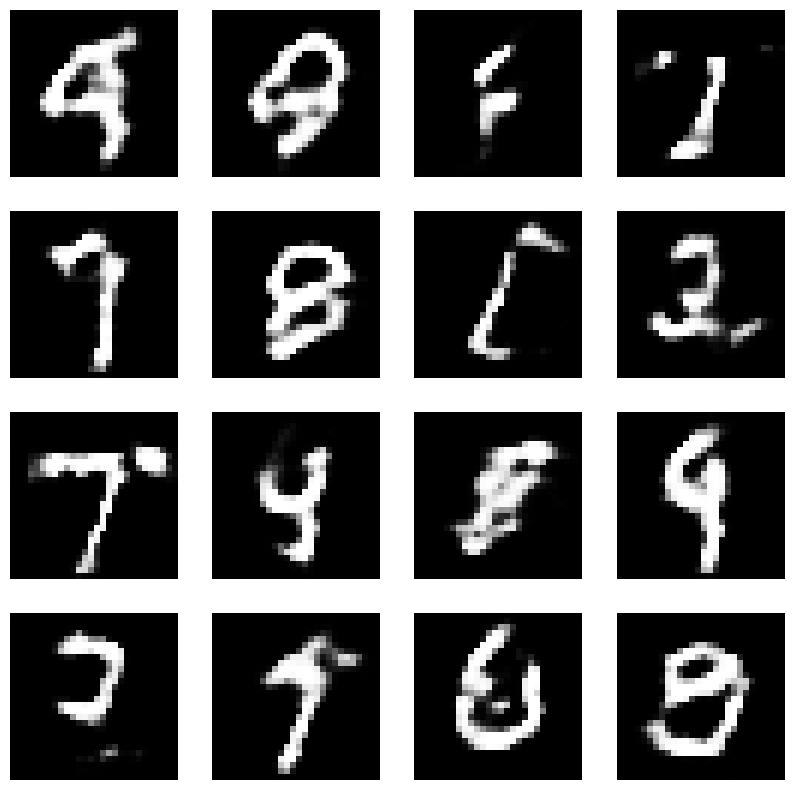

Epoch 66


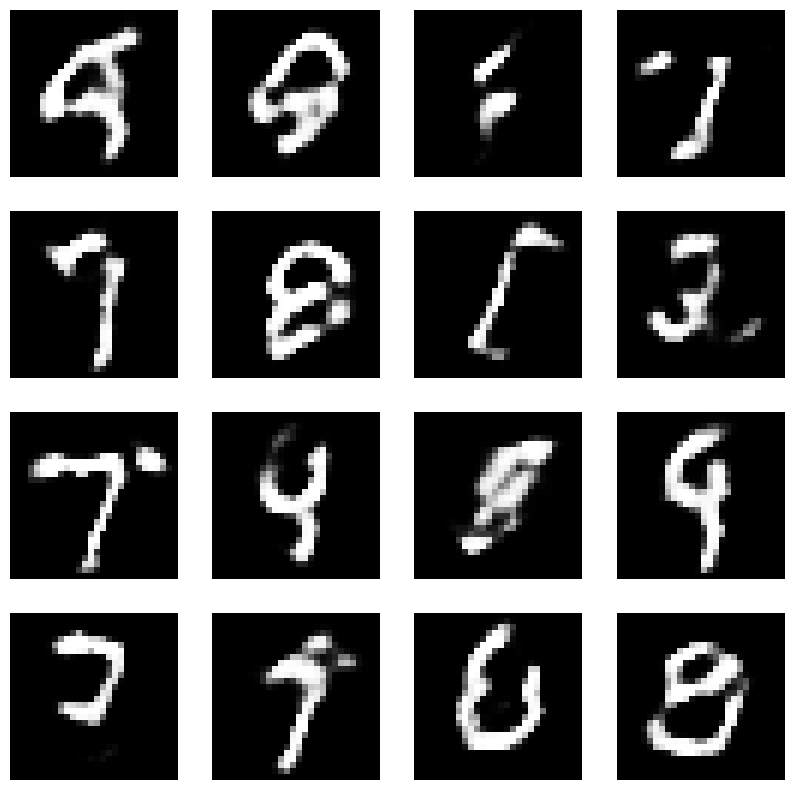

Epoch 67


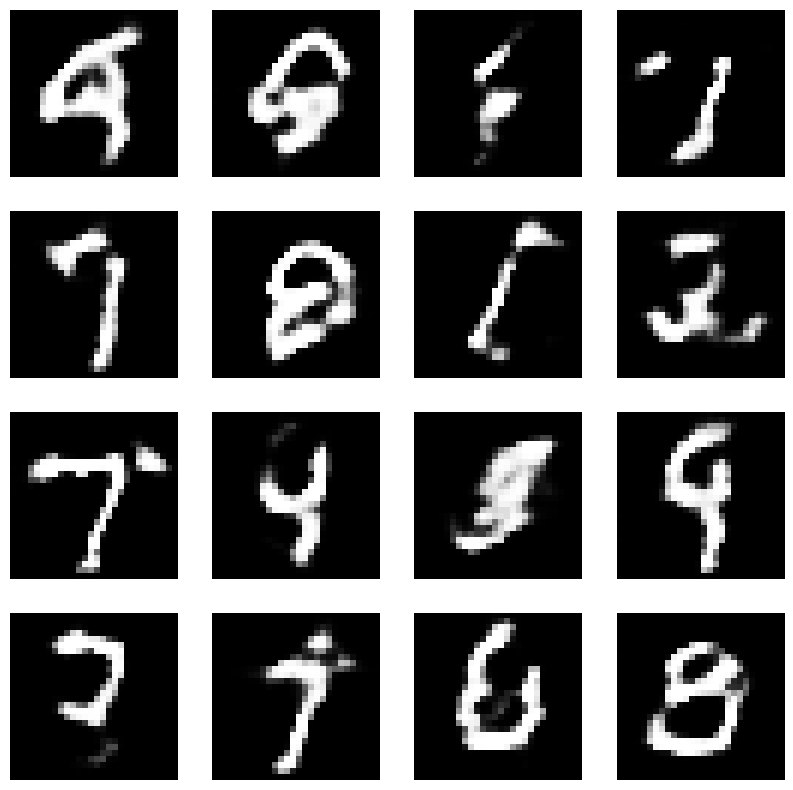

Epoch 68


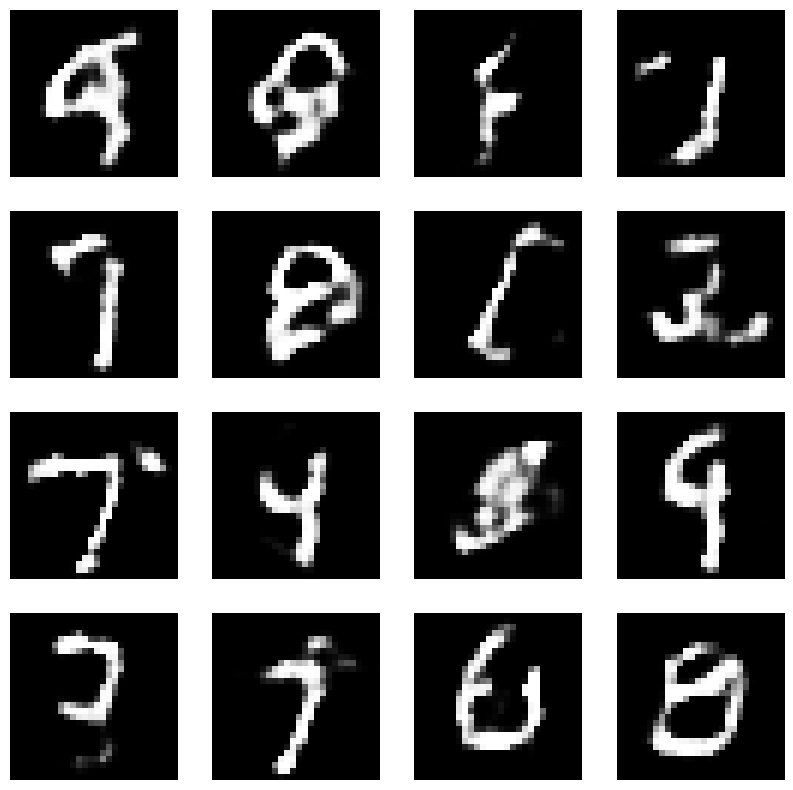

Epoch 69


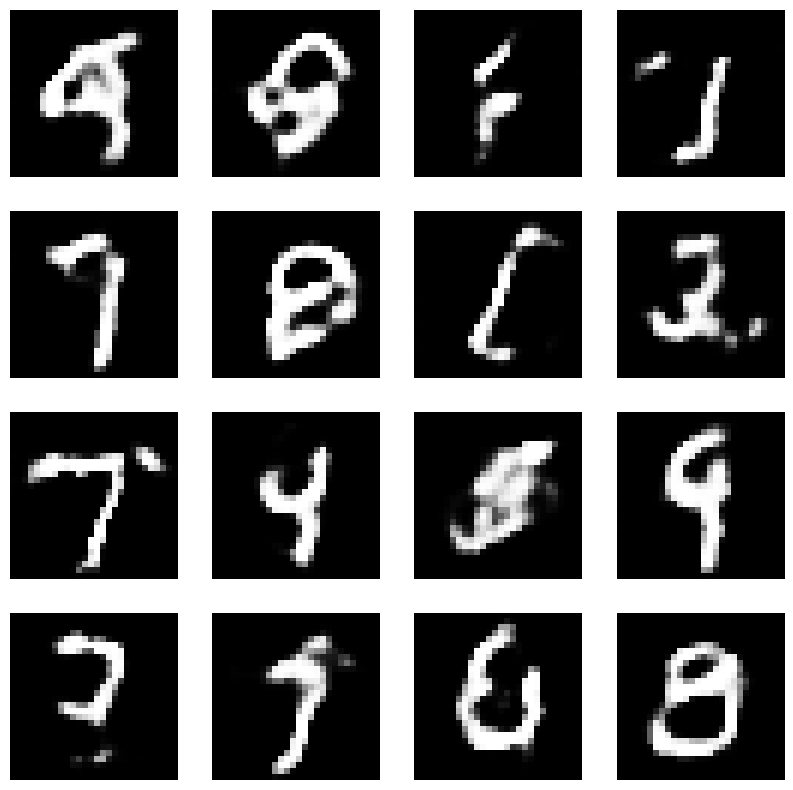

Epoch 70


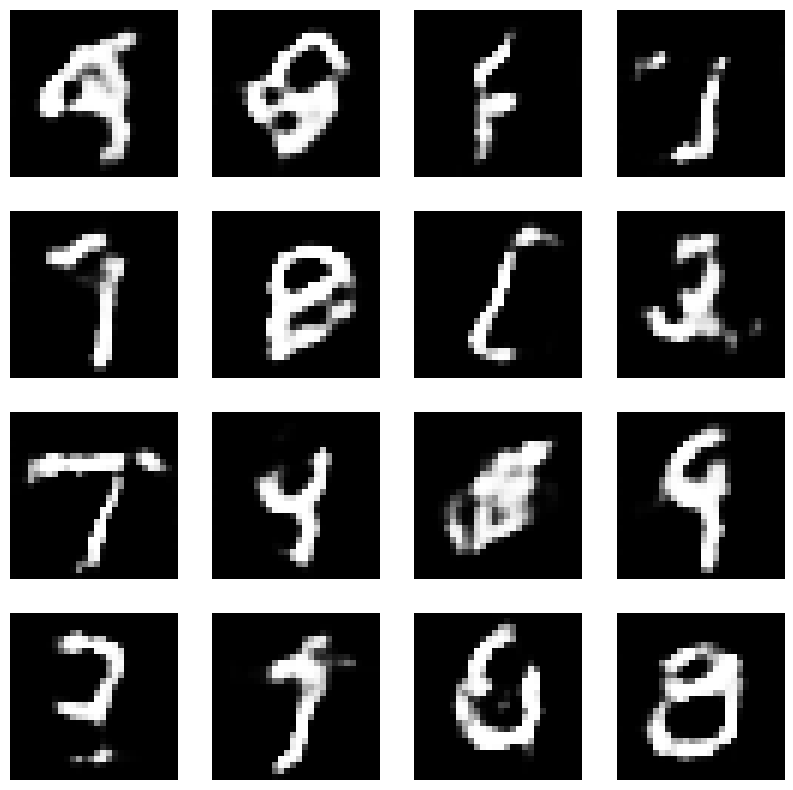

Epoch 71


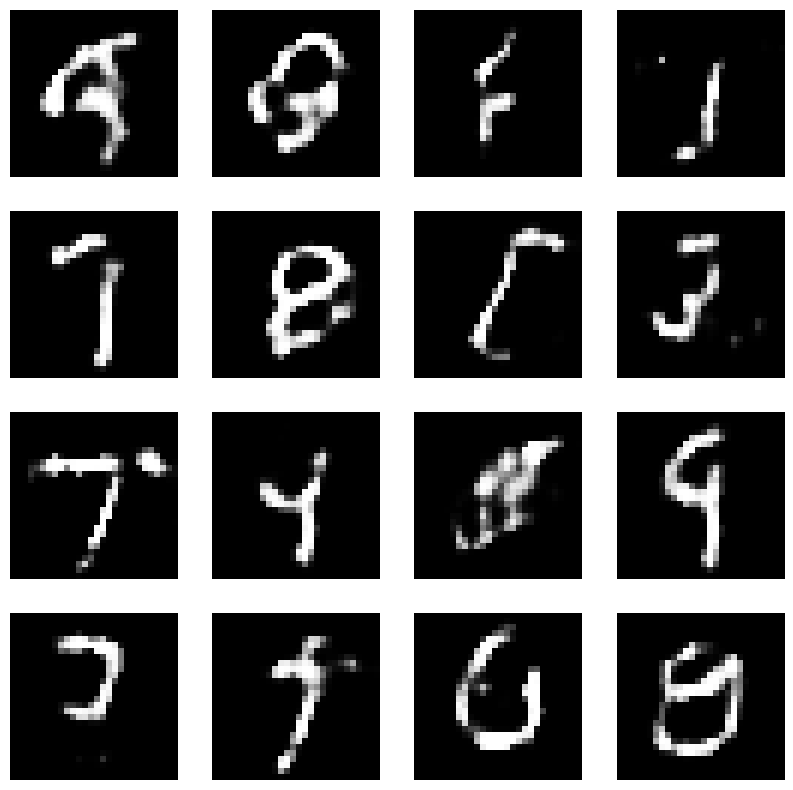

Epoch 72


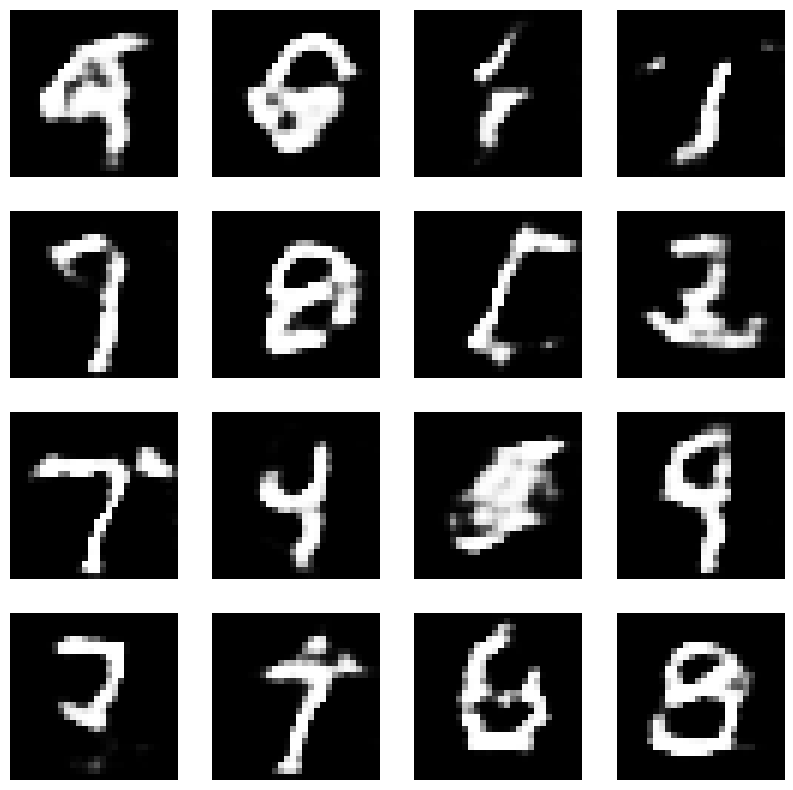

Epoch 73


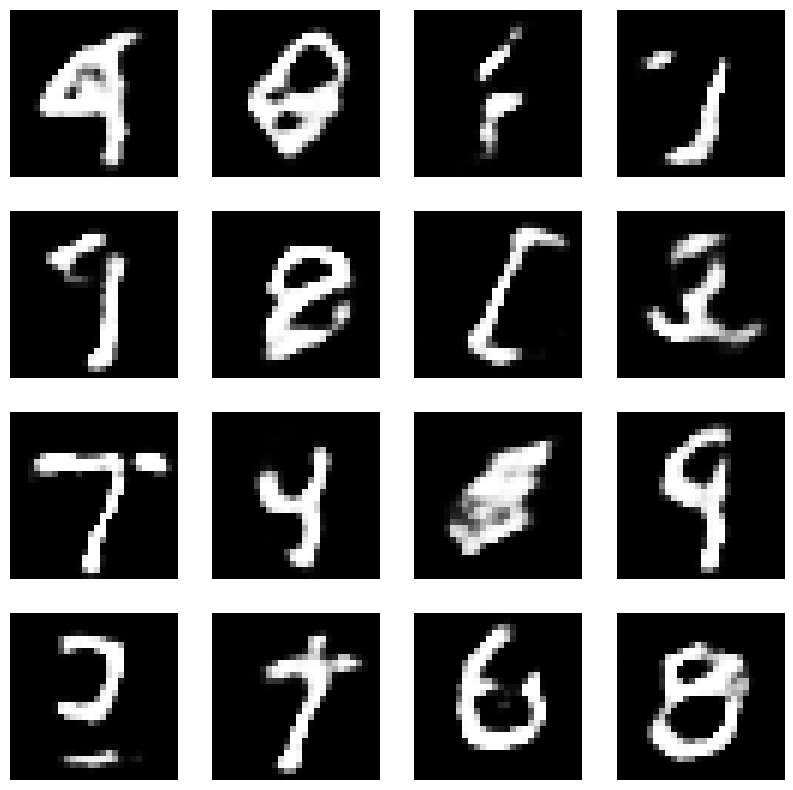

Epoch 74


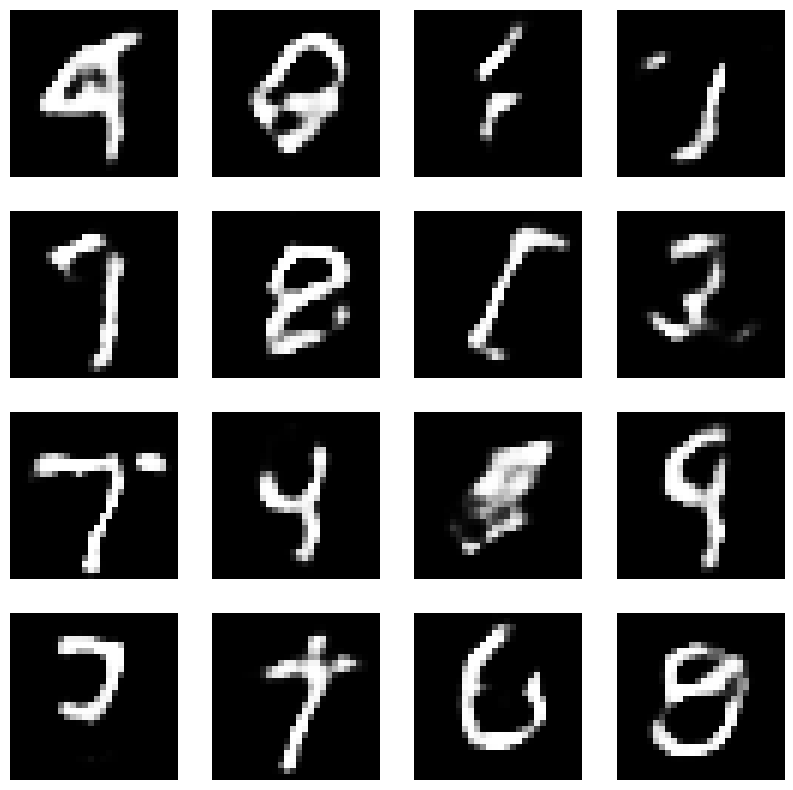

Epoch 75


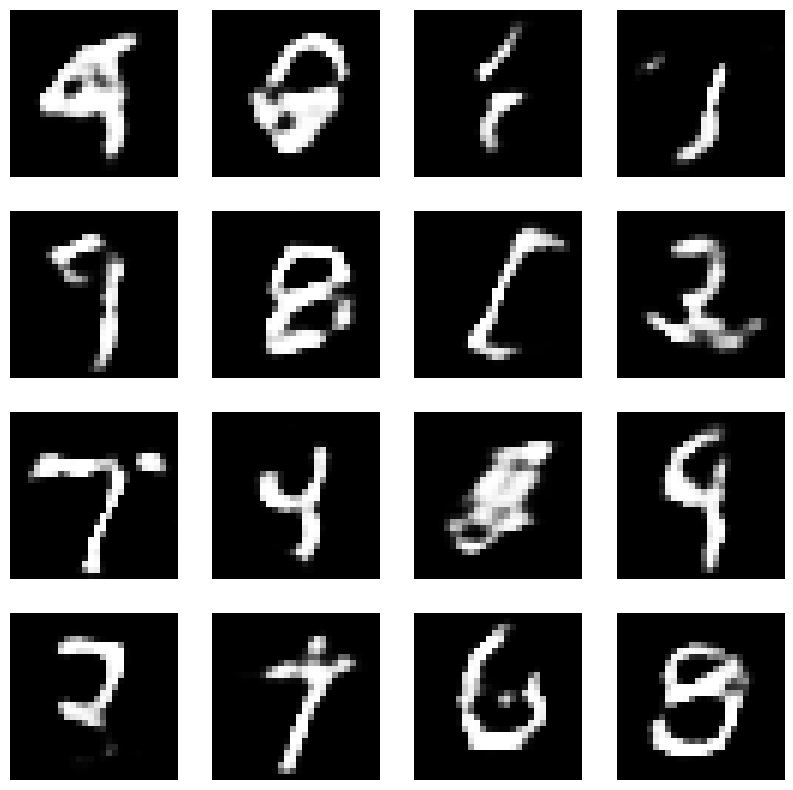

Epoch 76


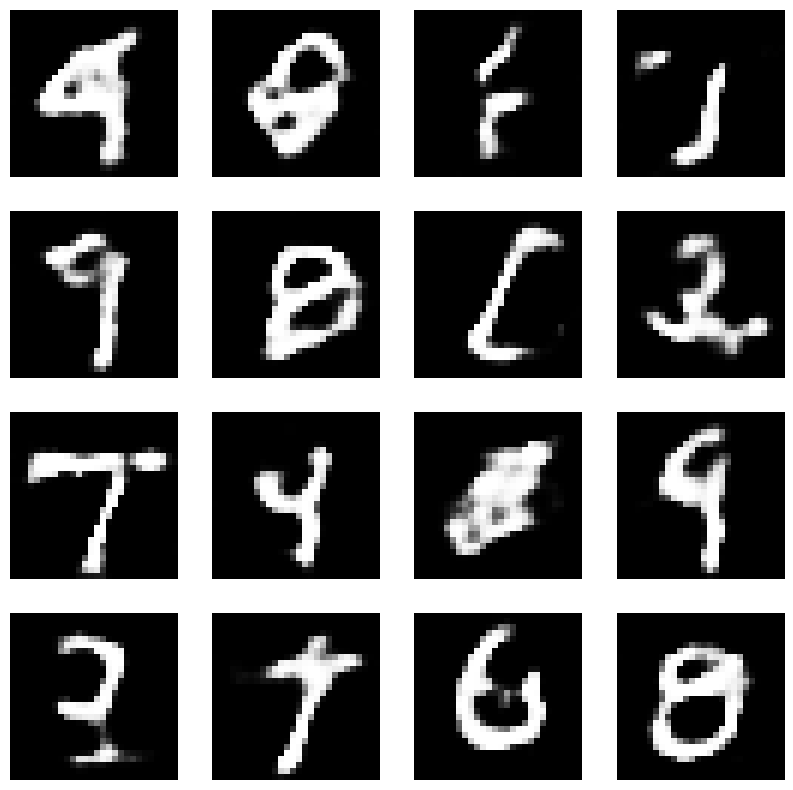

Epoch 77


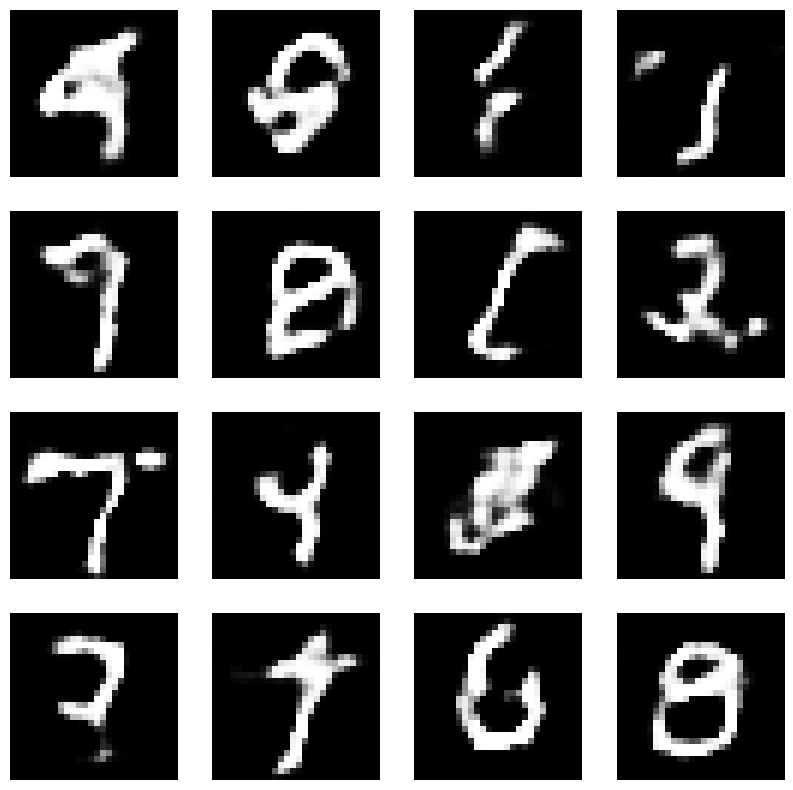

Epoch 78


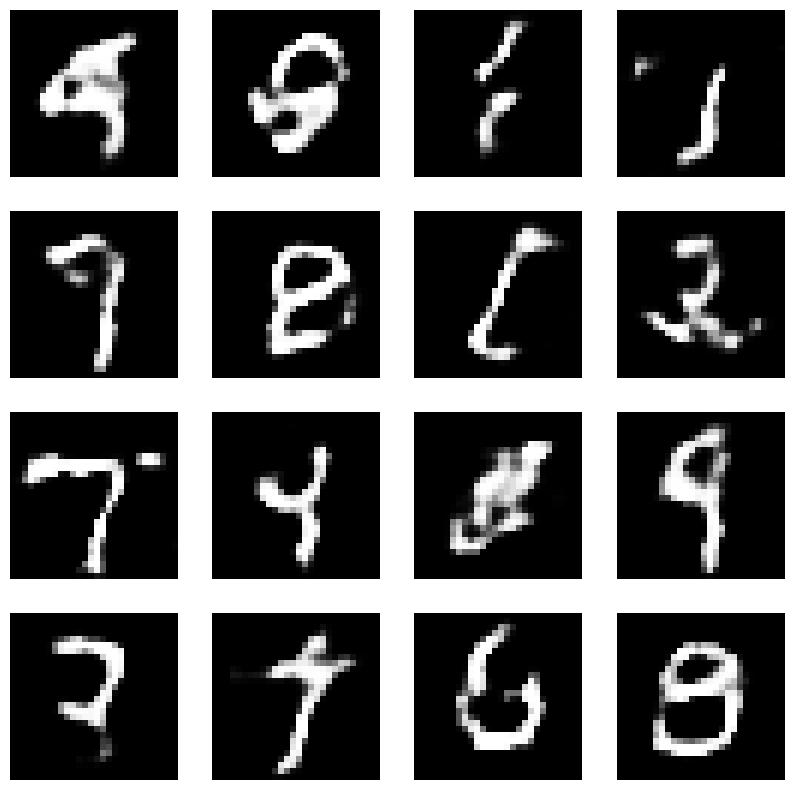

Epoch 79


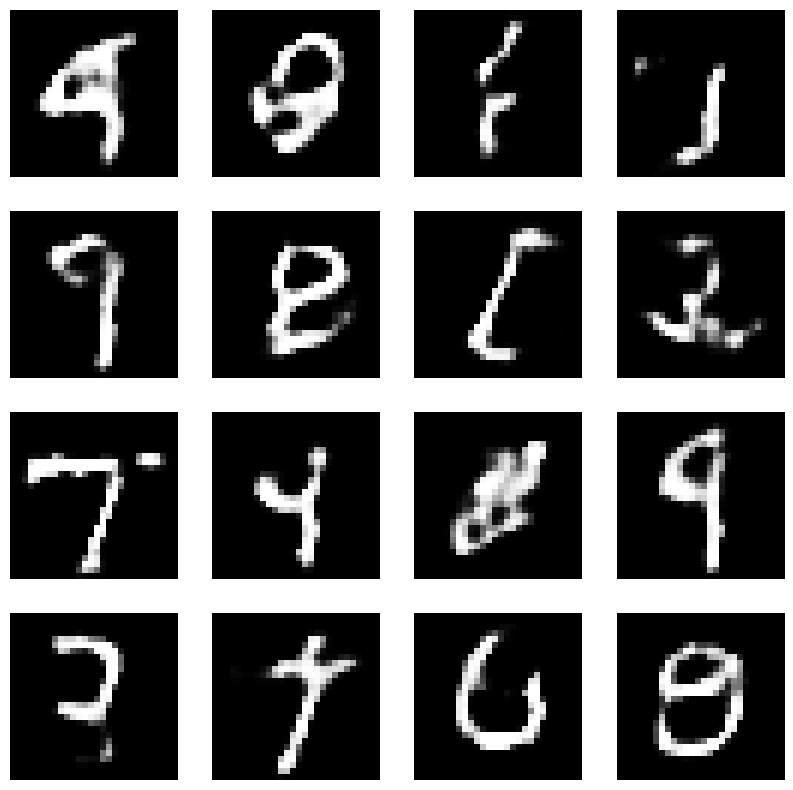

Epoch 80


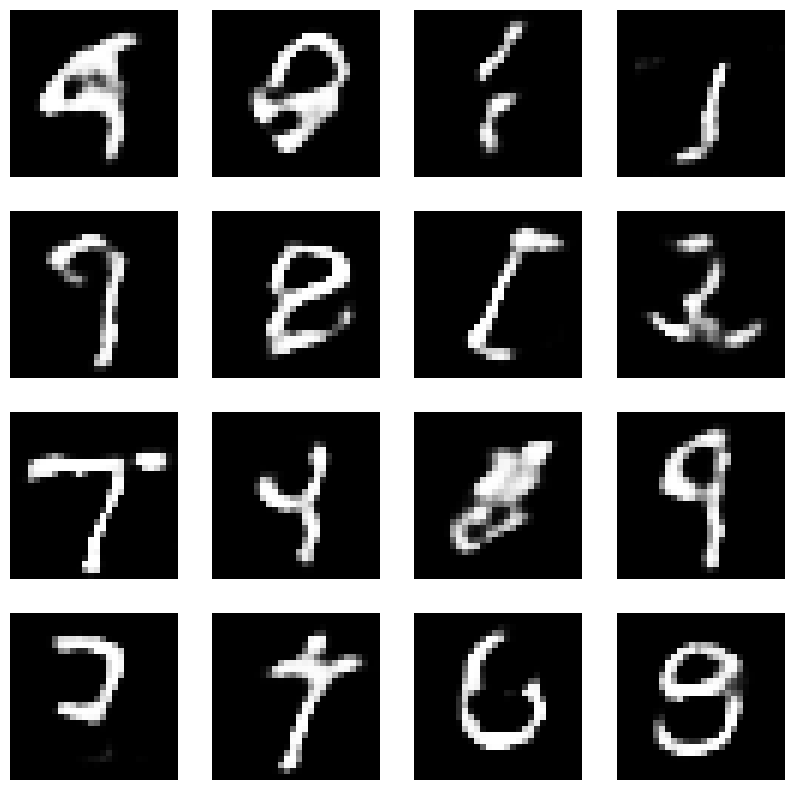

Epoch 81


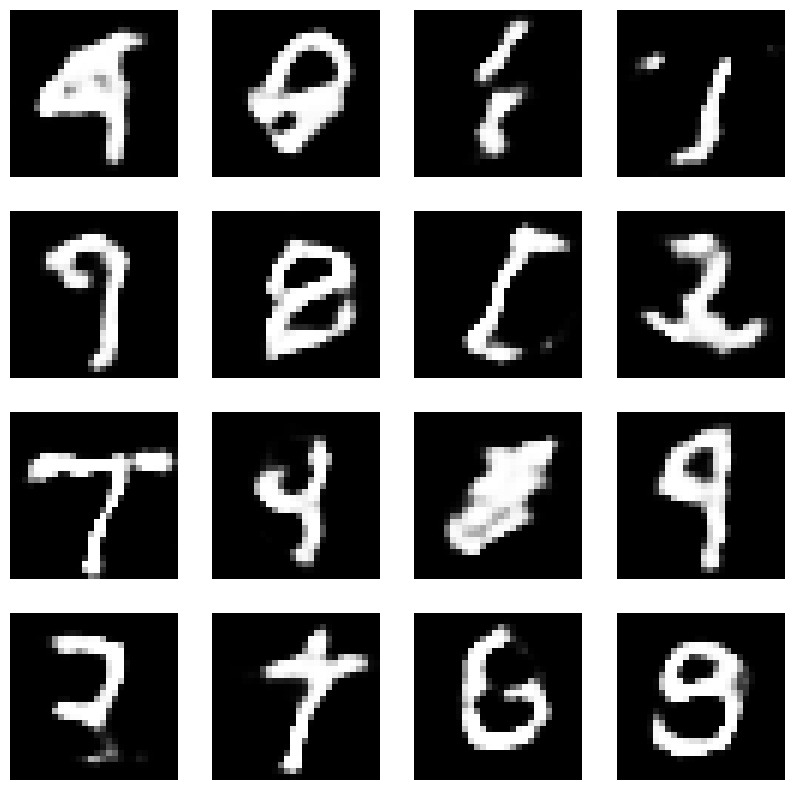

Epoch 82


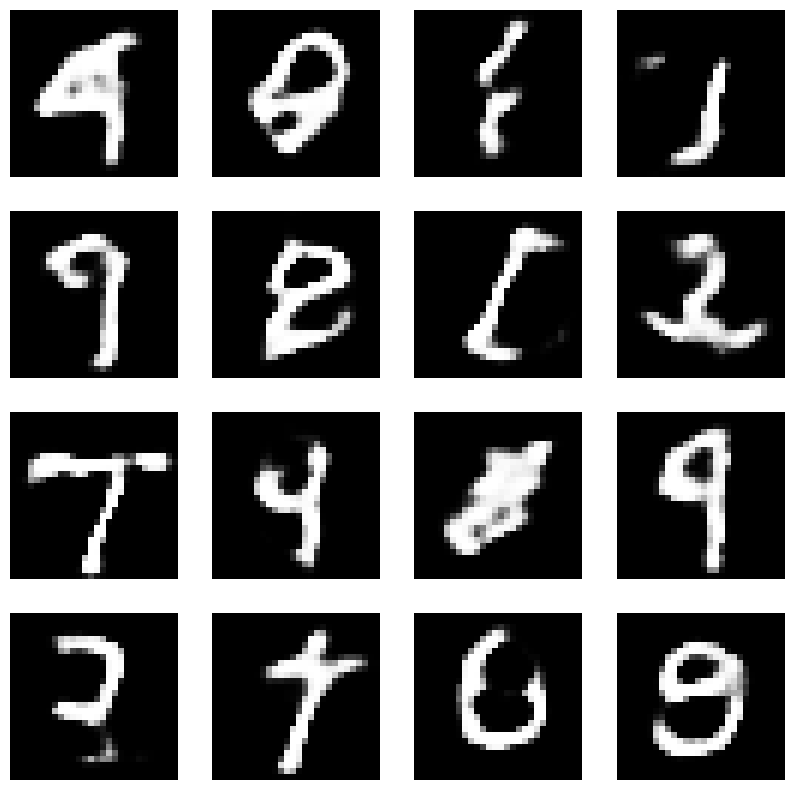

Epoch 83


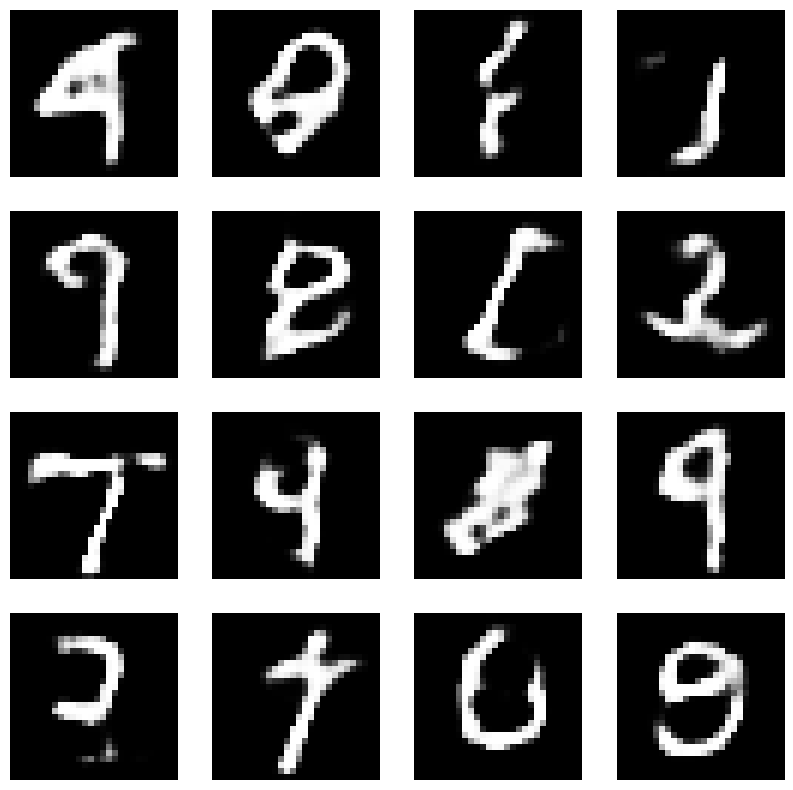

Epoch 84


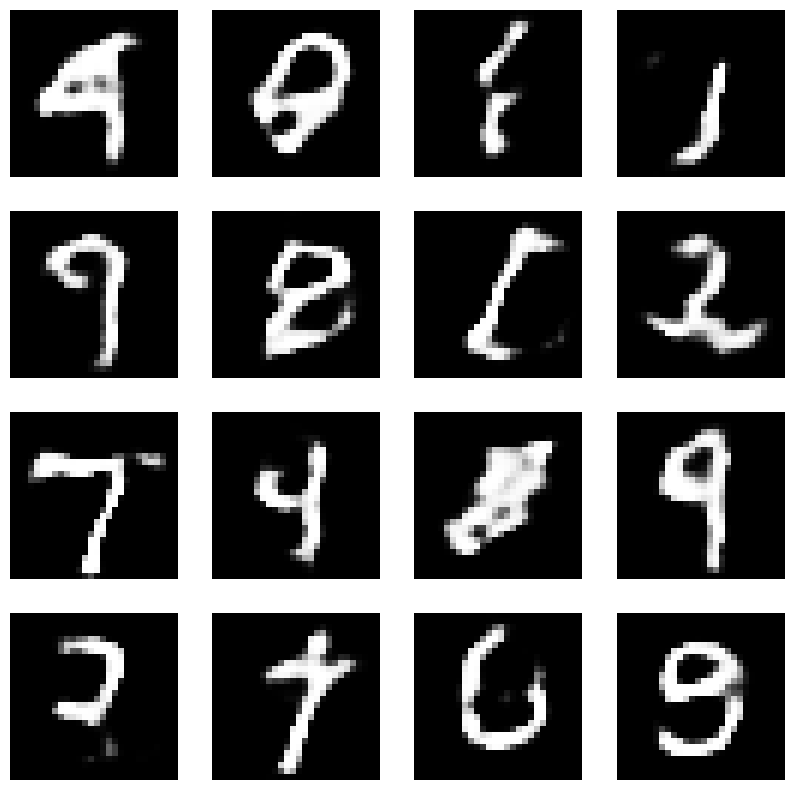

Epoch 85


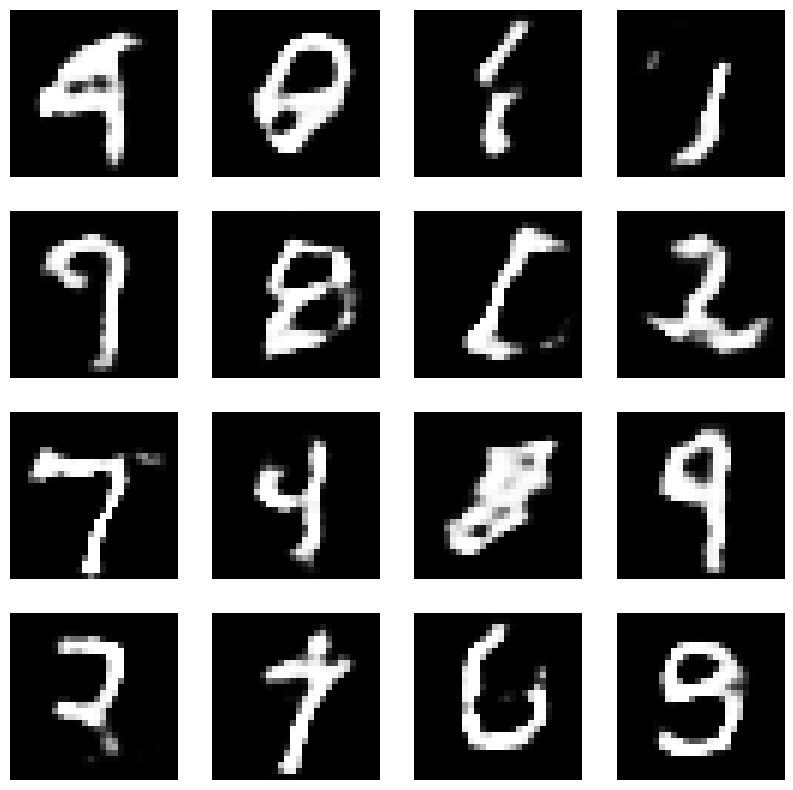

Epoch 86


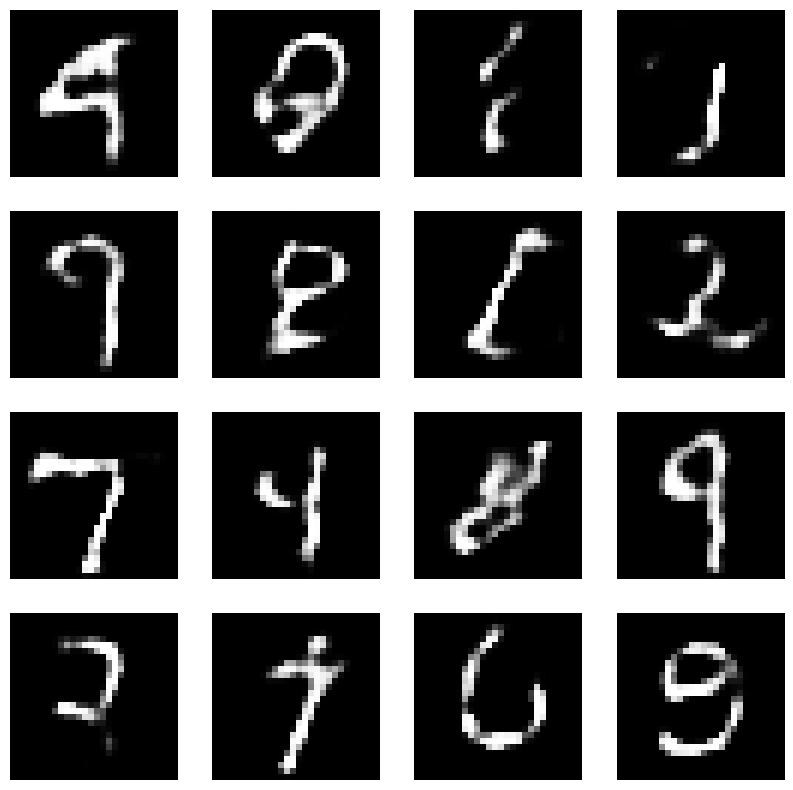

Epoch 87


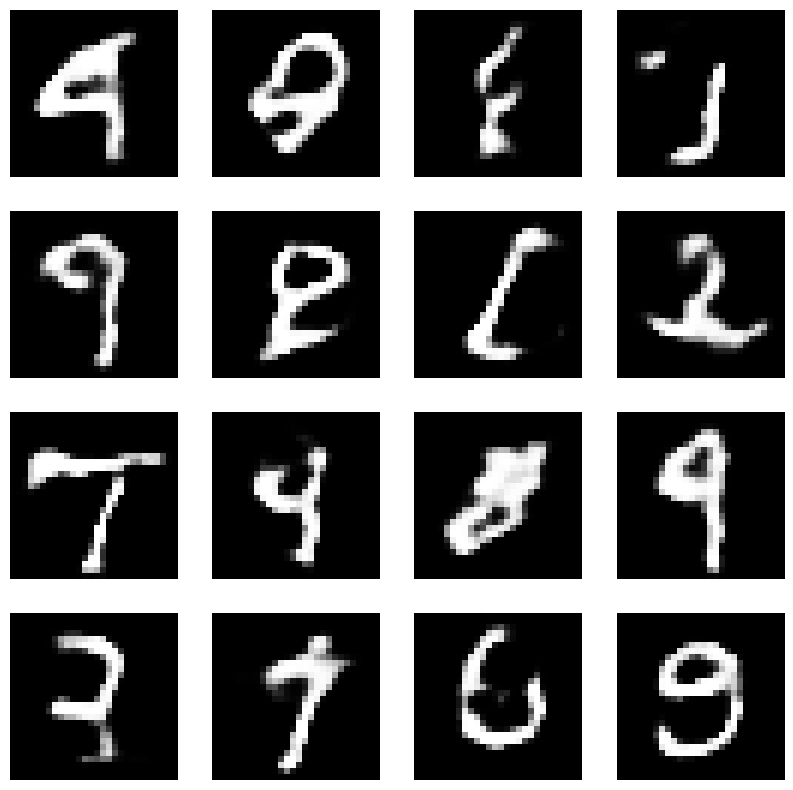

Epoch 88


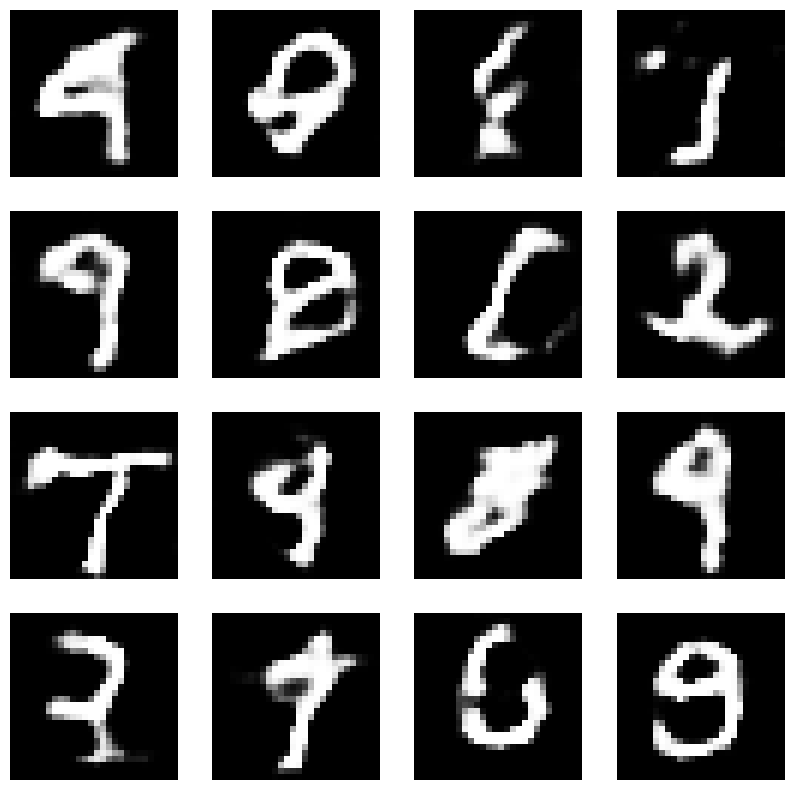

Epoch 89


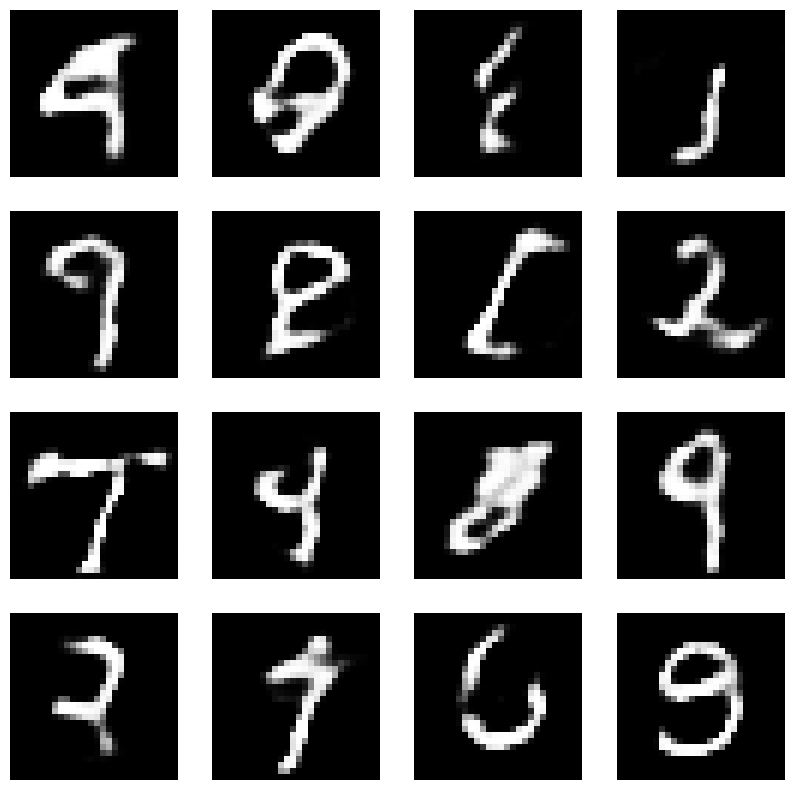

Epoch 90


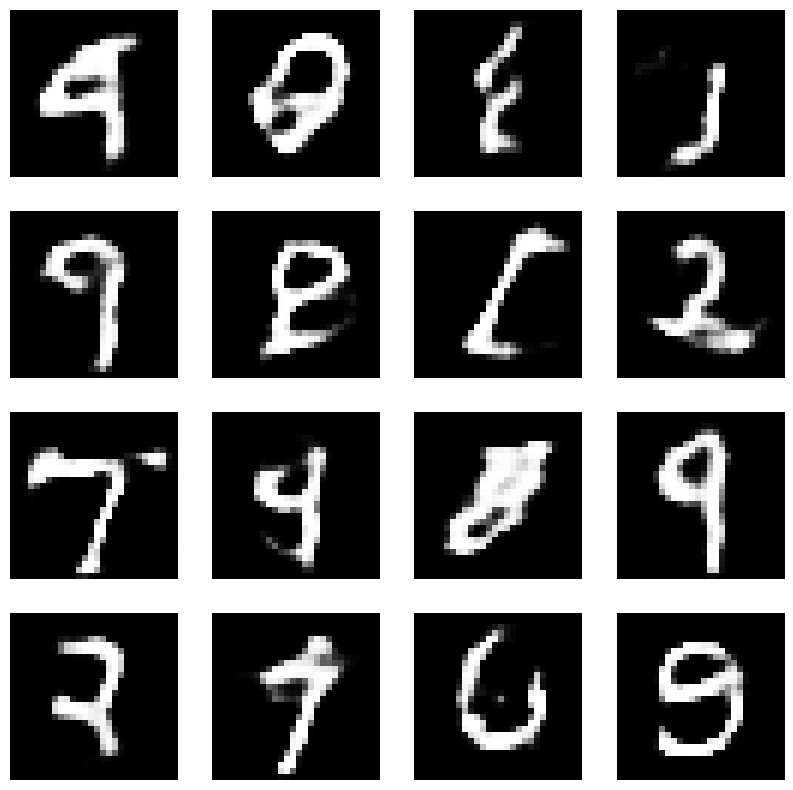

Epoch 91


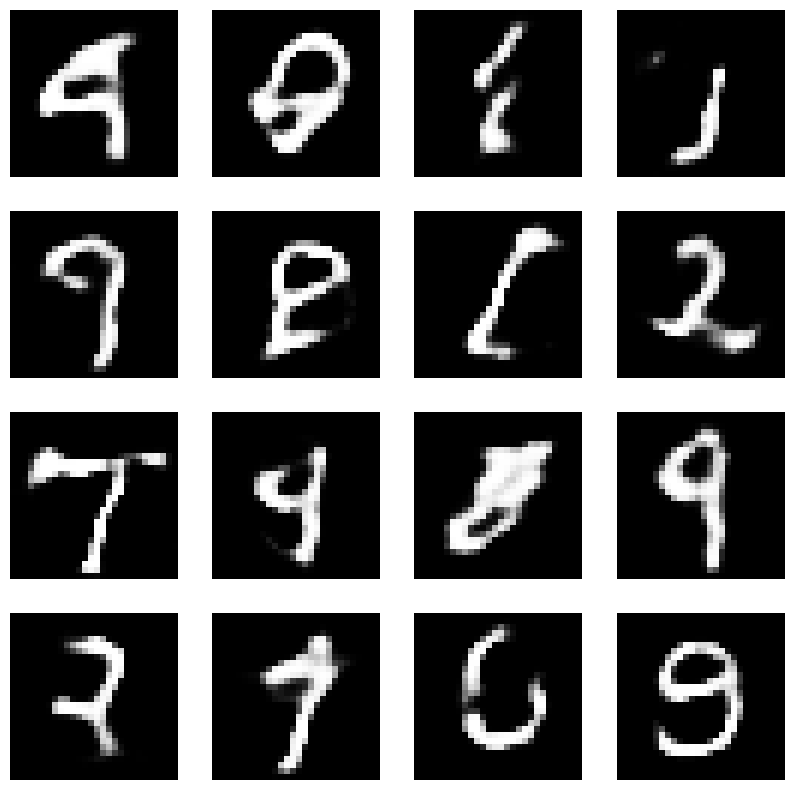

Epoch 92


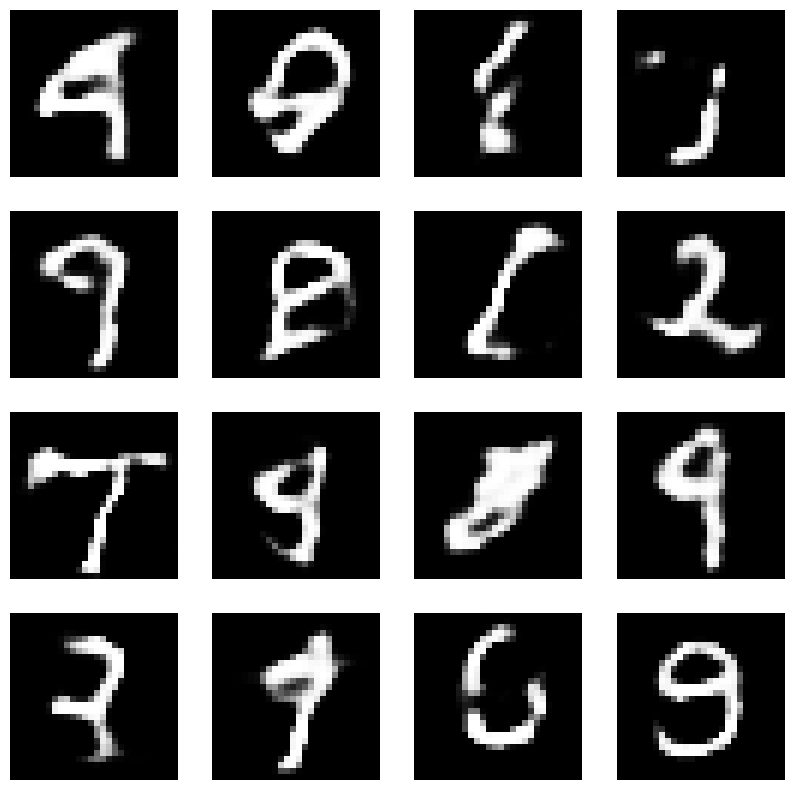

Epoch 93


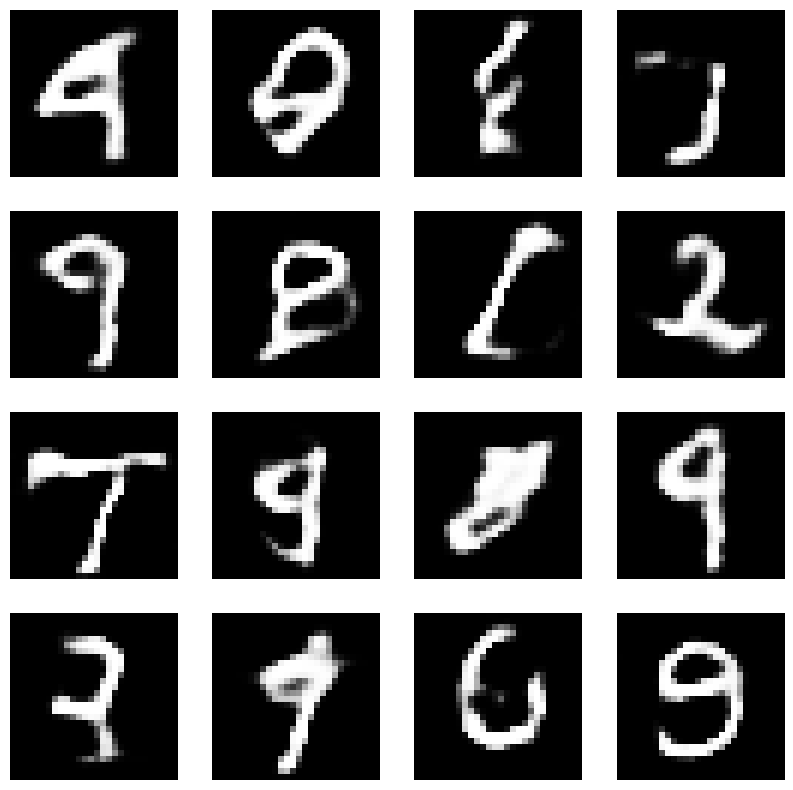

Epoch 94


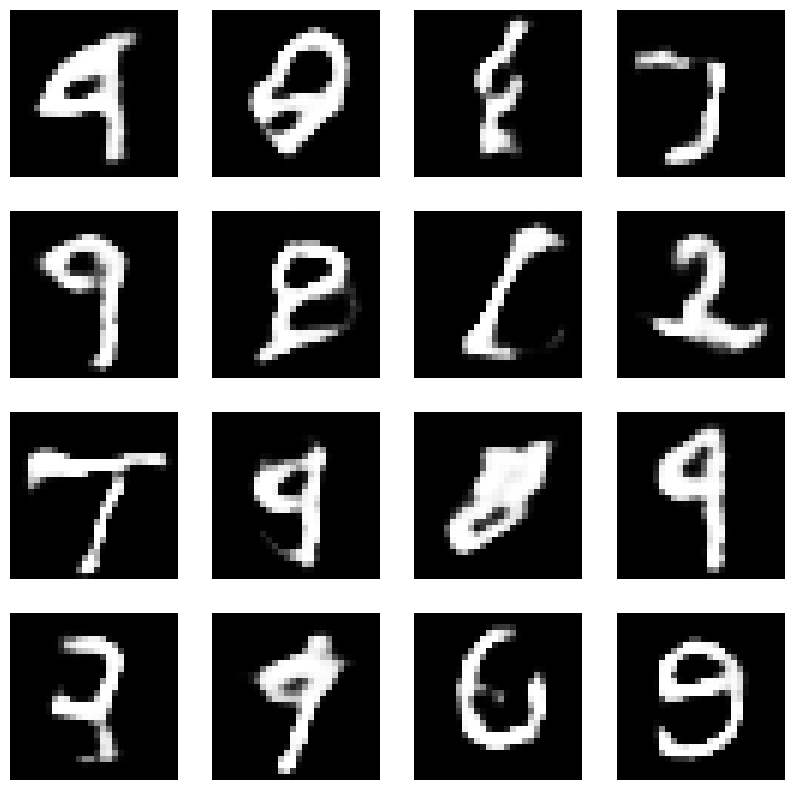

Epoch 95


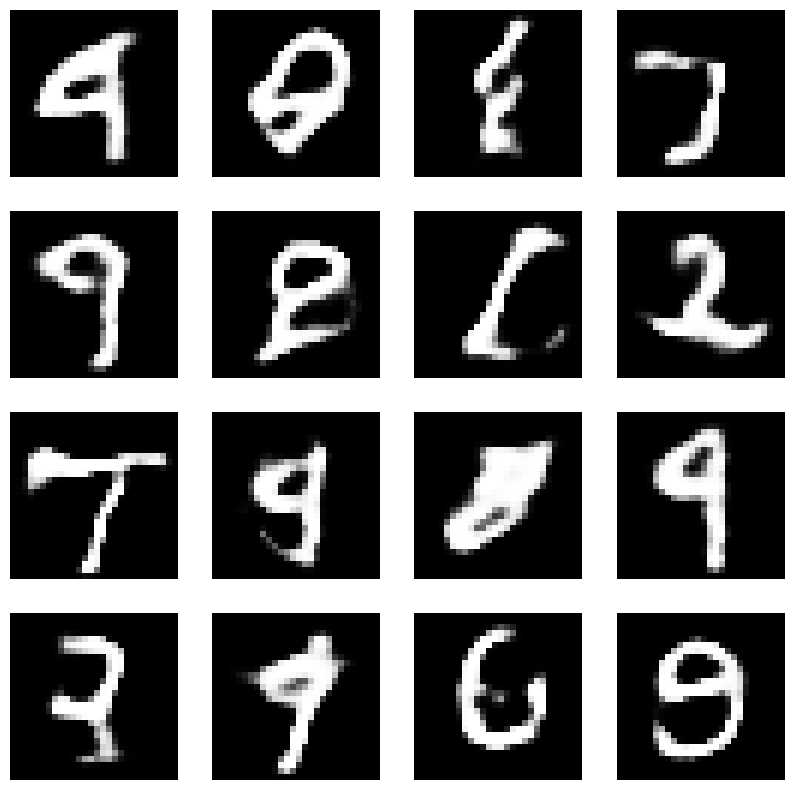

Epoch 96


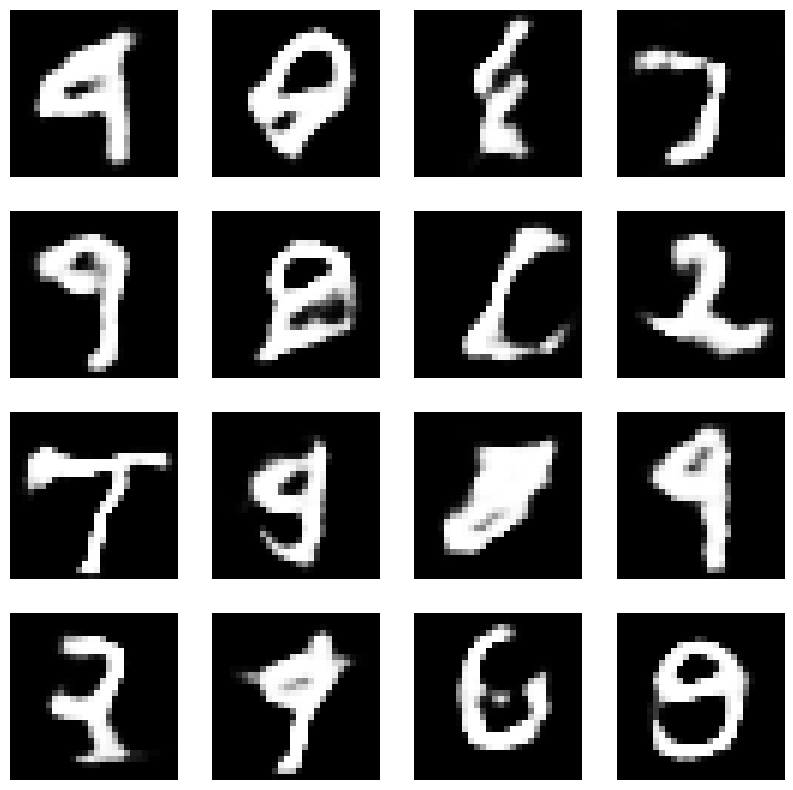

Epoch 97


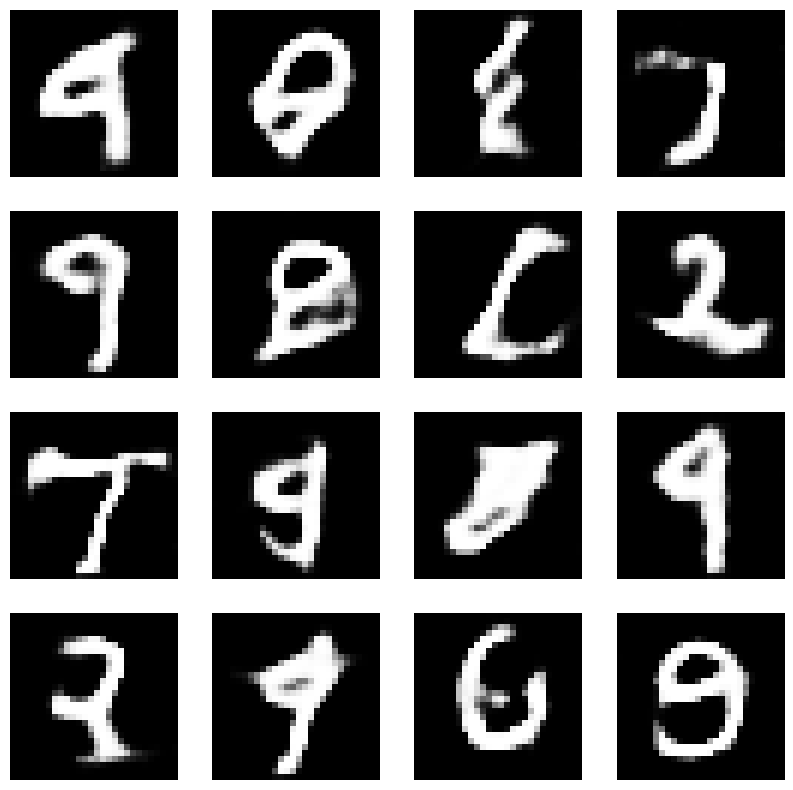

Epoch 98


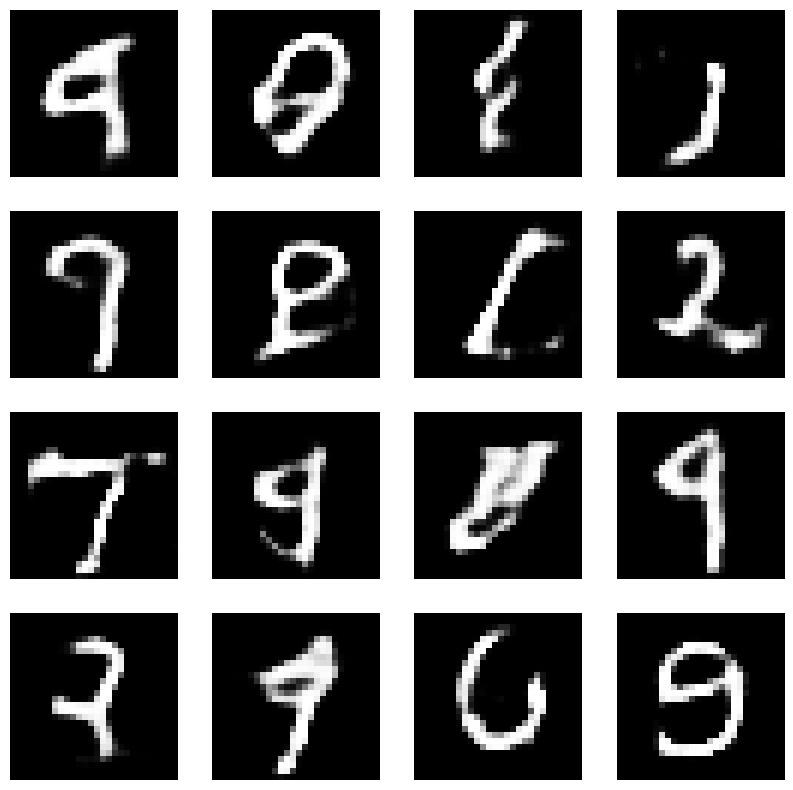

Epoch 99


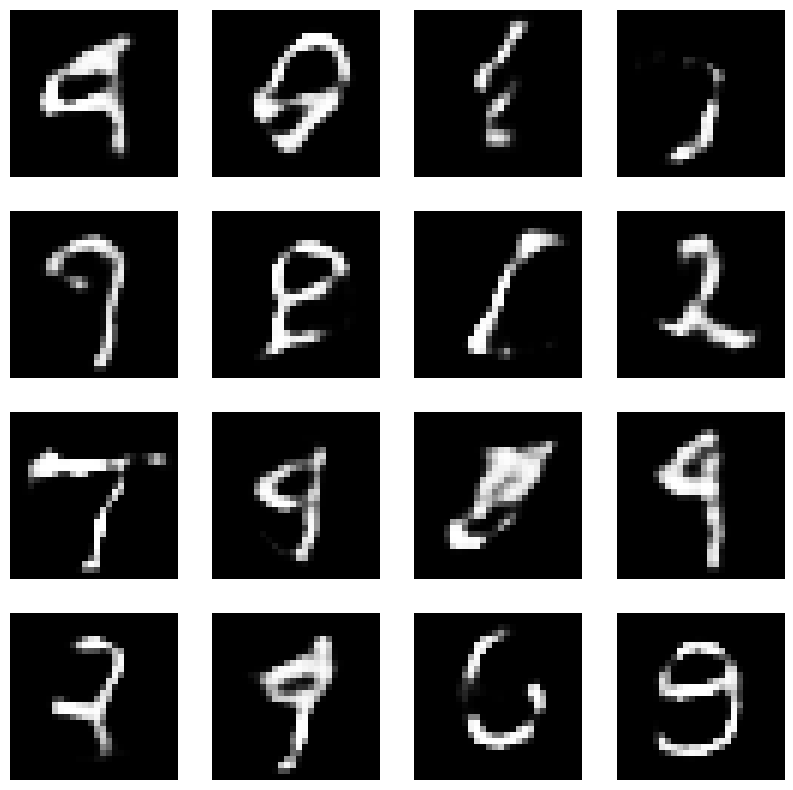

Epoch 100


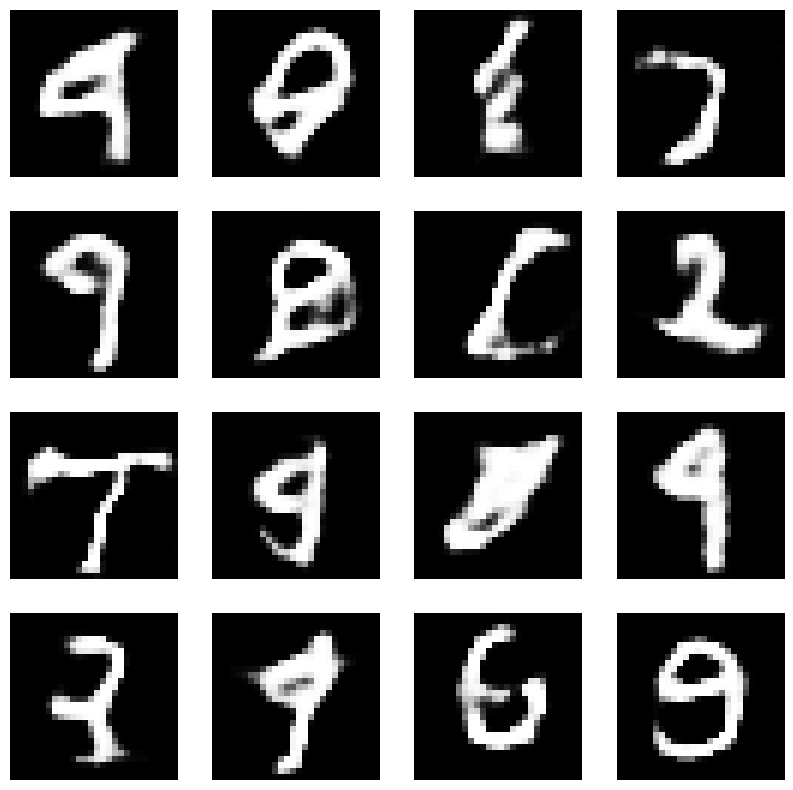

In [35]:
gan_train(X_train, EPOCHS, test_images)